<a href="https://colab.research.google.com/github/Rika0912/Carerha-2024/blob/main/Final_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Power Demand**




---



## [1]  Data Exploration and Analysis (EDA)

---



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, shapiro, levene, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as ols
from scipy.stats import chi2_contingency, chi2

### a. Data Cleaning and Preparation

---



In [ ]:
                       ######### Data Connection ###########
file_path_power = "/content/drive/MyDrive/Colab Notebooks/Carerha DataScience/Assignments/Final Project 1/Final Project/Demand.xlsx"
demand = pd.read_excel(file_path_power)
demand.head()

,DemandDateTime,Demand
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal


In [ ]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DemandDateTime  17520 non-null  datetime64[ns]
 1   Demand          17520 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 273.9+ KB


The data types is represented well so no need to change or transform and there is no null values.

In [ ]:
demand["Demand"].unique()

array(['Normal', 'Low', 'Normall', 'High', 'normal', 'high'], dtype=object)

I have noticed that 'Normal','Normall', 'normal' consider different values and also 'High', 'high' so we need to unified.

In [ ]:
# Unify the values
demand['Demand'] = demand['Demand'].replace({'Normal': 'Normal', 'Normall': 'Normal', 'normal': 'Normal', 'High': 'High', 'high': 'High'})
demand["Demand"].unique()

array(['Normal', 'Low', 'High'], dtype=object)

In [ ]:
# Handling Missing Values
print("\nMissing Values Summary:")
print(demand.isnull().sum())


Missing Values Summary:
DemandDateTime    0
Demand            0
dtype: int64


There is no missing values.

### b- Feature Extraction

---



In [ ]:
                            ######## Data Transformation #########
# Rename DemandDateTime column as DateTime
demand.columns = demand.columns.str.replace('DemandDateTime', 'DateTime')

demand['Date'] = pd.to_datetime(demand['DateTime']).dt.date
demand['Time'] = pd.to_datetime(demand['DateTime']).dt.time


# Extract additional time-based features
demand['Hour'] = pd.to_datetime(demand['Time'], format='%H:%M:%S').dt.hour
demand['Month'] = pd.to_datetime(demand['Date'], format='%Y-%m-%d').dt.month
demand['DayOfWeek'] = pd.to_datetime(demand['Date'], format='%Y-%m-%d').dt.day_name()

# Extract time of day categories
demand['TimeOfDay'] = pd.cut(demand['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)

#Extract weekend or weekday
demand['DayType'] = demand['DayOfWeek'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
demand.head()

,DateTime,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType
0,2013-01-01 00:00:00,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday
1,2013-01-01 00:30:00,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday
2,2013-01-01 01:00:00,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday
3,2013-01-01 01:30:00,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday
4,2013-01-01 02:00:00,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday


In [ ]:
demand['CostDemand'] = demand['Demand'].map({'High': 77.21, 'Normal': 19.46, 'Low': 6.89})
demand.head()

,DateTime,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand
0,2013-01-01 00:00:00,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday,19.46
1,2013-01-01 00:30:00,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday,19.46
2,2013-01-01 01:00:00,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday,19.46
3,2013-01-01 01:30:00,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday,19.46
4,2013-01-01 02:00:00,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday,19.46


In [ ]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DateTime    17520 non-null  datetime64[ns]
 1   Demand      17520 non-null  object        
 2   Date        17520 non-null  object        
 3   Time        17520 non-null  object        
 4   Hour        17520 non-null  int32         
 5   Month       17520 non-null  int32         
 6   DayOfWeek   17520 non-null  object        
 7   TimeOfDay   17520 non-null  category      
 8   DayType     17520 non-null  object        
 9   CostDemand  17520 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), int32(2), object(5)
memory usage: 1.1+ MB


### c- Exploratory Analysis

---



In [ ]:
# Summary statistics
demand.describe()

,DateTime,Hour,Month,CostDemand
count,17520,17520.000000,17520.000000,17520.000000
mean,2013-07-02 11:45:00,11.500000,6.526027,20.866438
min,2013-01-01 00:00:00,0.000000,1.000000,6.890000
25%,2013-04-02 05:52:30,5.750000,4.000000,19.460000
50%,2013-07-02 11:45:00,11.500000,7.000000,19.460000
75%,2013-10-01 17:37:30,17.250000,10.000000,19.460000
max,2013-12-31 23:30:00,23.000000,12.000000,77.210000
std,NaN,6.922384,3.447950,12.767290


**Data Collection Period:**

  **DemandDateTime:**
* min: The earliest recorded datetime is January 1st, 2013, at 00:00:00.
* max: The latest recorded datetime is December 31st, 2013, at 23:30:00.

      the data likely spans a full year of 2013
    
**Month:**

* min: 1 (January)
* max: 12 (December)

Conclusion: Reinforces that data covers all months of the year.

**Data Frequency:**

**DemandDateTime:**
* count: There are 17,520 total datetime entries.
Considering there are 8,760 hours in a year, and your data has almost double that, therefore the data might have been collected at **half-hourly intervals**. This aligns with 365 days * 48 half-hour periods = 17,520.

**Hour:**
* min: 0
* max: 23

Conclusion: Data likely collected at half-hourly intervals, as there are 48 half-hour periods in a day (0:00, 0:30, 1:00, and so on). This is further supported by the count of 'DemandDateTime' being 17,520 (365 days * 48 half-hour periods = 17,520).

**Central Tendency:**

**DemandDateTime:**
* mean: The average datetime falls on **July 2nd, 2013, at 11:45:00**. This represents the midpoint of the data collection period.
* 50% (median): This also aligns with the mean, confirming that **the data is evenly distributed throughout the year.**

**Hour:**

* mean: 11.5
* 50% (median): 11.5

Conclusion: The average hour of data collection is around noon, further supporting even distribution.

**Month:**

* mean: 6.526
* 50% (median): 7 (July)

Conclusion: The average month is close to July, aligning with the 'DemandDateTime' mean.

**Data Distribution:**

**DemandDateTime:**
* 25% (first quartile): 25% of the datetime values are before **April 2nd, 2013, at 05:52:30.**
* 75% (third quartile): 75% of the datetime values are before **October 1st, 2013, at 17:37:30**.

         fairly even distribution of data points across the year, with a slight skew towards the latter half of the year.

**Hour:**

* std: 6.922

Conclusion: Moderate spread of data across hours of the day.

**Month:**

* std: 3.447

Conclusion: Data is fairly evenly distributed across months.

**Overall Insights:**

The DemandDateTime data appears to cover a full year of 2013, collected at approximately **half-hourly intervals**. The data is evenly distributed, with the mean and median falling on July 2nd, 2013, around midday. This suggests a consistent and relatively complete dataset for analyzing power demand throughout the year.


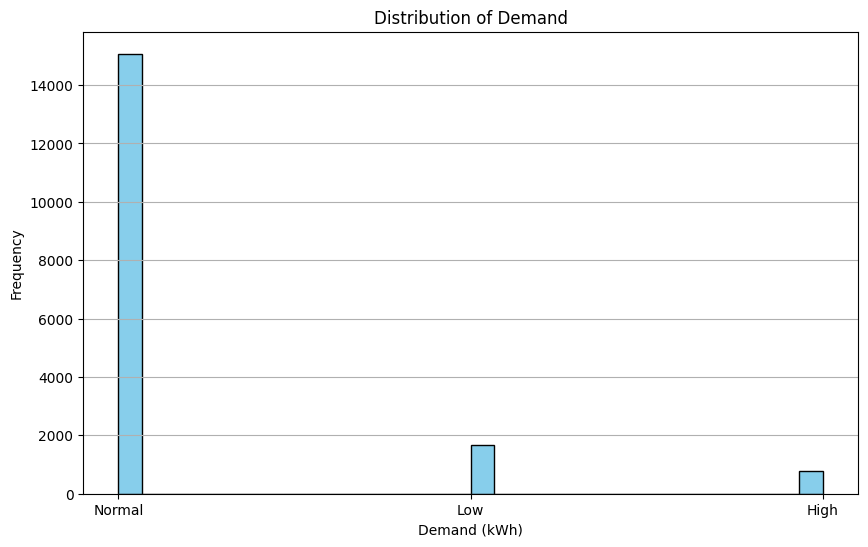

In [ ]:
# ---- Histograms for Distribution of Demand ----
plt.figure(figsize=(10, 6))
plt.hist(demand['Demand'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Demand')
plt.xlabel('Demand (kWh)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Based on the information provided in the analysis of the image, it can be inferred that the distribution of demand in kilowatt-hours (kWh) is categorized into three levels: Normal, Low, and High. The Normal demand category has the highest frequency, indicating that it is the most common level of energy demand, with a value close to 14,000 kWh. In contrast, the Low demand category has the lowest frequency, with a value of 2,000 kWh, while the High demand category falls in between with a frequency of 1,000 kWh.

Understanding this distribution of energy demand levels can be beneficial for energy planning and management. It indicates that Normal demand is the most prevalent, suggesting that it represents typical energy consumption patterns. The Low and High demand categories, although less frequent, provide insights into lower and higher energy consumption levels, respectively. This information can help in optimizing energy distribution, implementing efficient energy management strategies, and ensuring a balanced and sustainable energy supply.

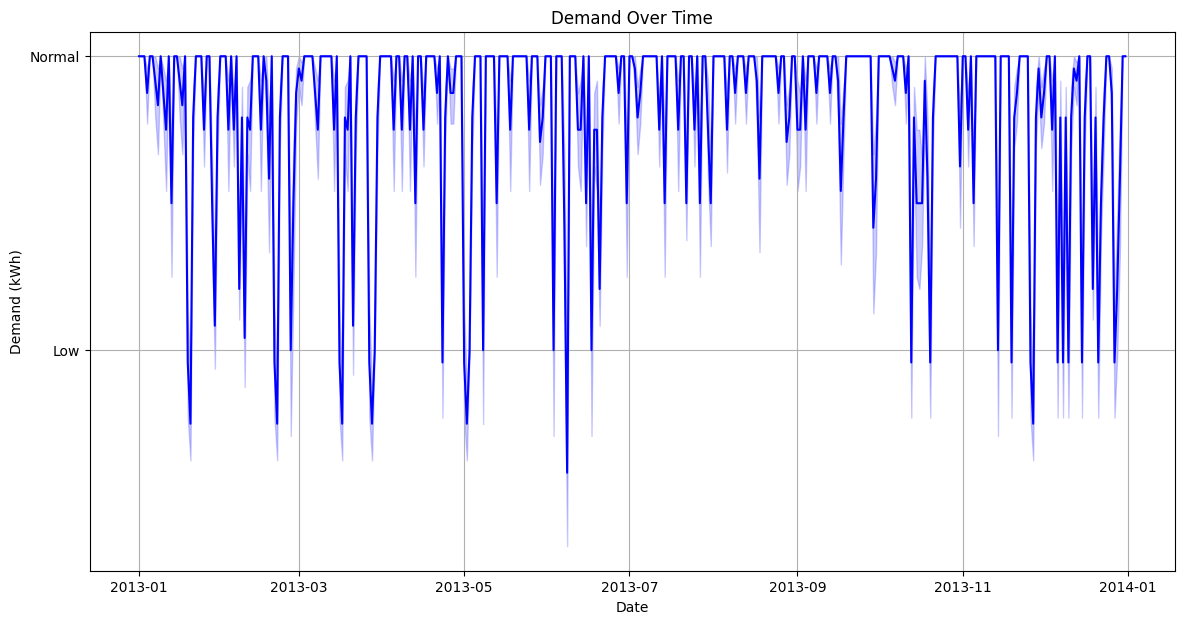

In [ ]:
# ---- Line Plot for Demand Over Time ----
plt.figure(figsize=(14, 7))
sns.lineplot(x=demand['Date'], y=demand['Demand'], color='blue')
plt.title('Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand (kWh)')
plt.grid()
plt.show()

Based on Line Plot,The demand exhibits significant fluctuations over time, with rapid changes from high to low values. This variability suggests that the demand is highly dynamic and may be influenced by external factors such as time of day, day of the week, seasonality, or unexpected events.
Seasonal Trends: The line plot spans one year (2013), but clear seasonal patterns are not immediately apparent in this visualization.Frequent Drops:There are consistent, sharp drops in demand to near-zero levels. These could indicate periods of inactivity, shutdowns, or data anomalies. It's important to verify whether these drops are real or due to missing or incorrect data.
Clustered Highs and Lows:High-demand periods are tightly clustered, and low-demand periods often appear grouped together. This could indicate recurring events such as peak hours of energy consumption or regular maintenance/outage schedules.
Potential Data Noise or Anomalies:The erratic spikes and dips suggest that there might be noise in the data or operational anomalies.


<ipython-input-13-32d70b06a5cd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hour', y='Demand', data=demand, palette='coolwarm')


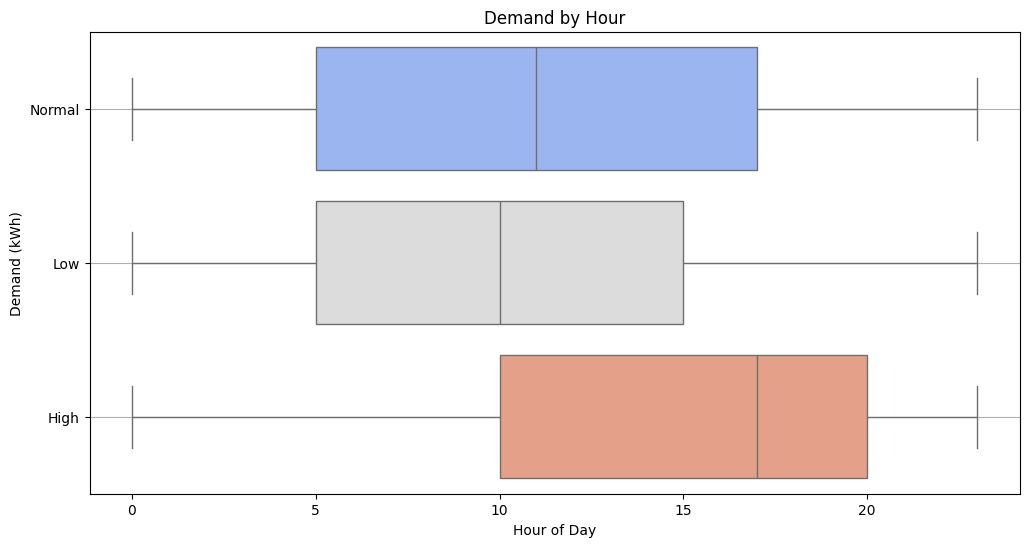

In [ ]:
# ---- Box Plot for Demand by Hour ----
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Demand', data=demand, palette='coolwarm')
plt.title('Demand by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Demand (kWh)')
plt.grid(axis='y')
plt.show()

Based on the box plot visualizing the demand by hour, it is evident that the demand levels fluctuate throughout the day. The normal demand peaks around midday, indicating a typical pattern of higher energy consumption during daytime hours. In contrast, the low and high demand levels show a more evenly distributed pattern across the hours, suggesting fluctuations in energy usage during different times of the day. This variation in demand levels by hour can provide valuable insights for energy management and resource allocation strategies.

<ipython-input-14-a8d57e95a4cb>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DayOfWeek', y='Demand', data=demand, estimator='mean', ci=None, palette='viridis')
<ipython-input-14-a8d57e95a4cb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayOfWeek', y='Demand', data=demand, estimator='mean', ci=None, palette='viridis')


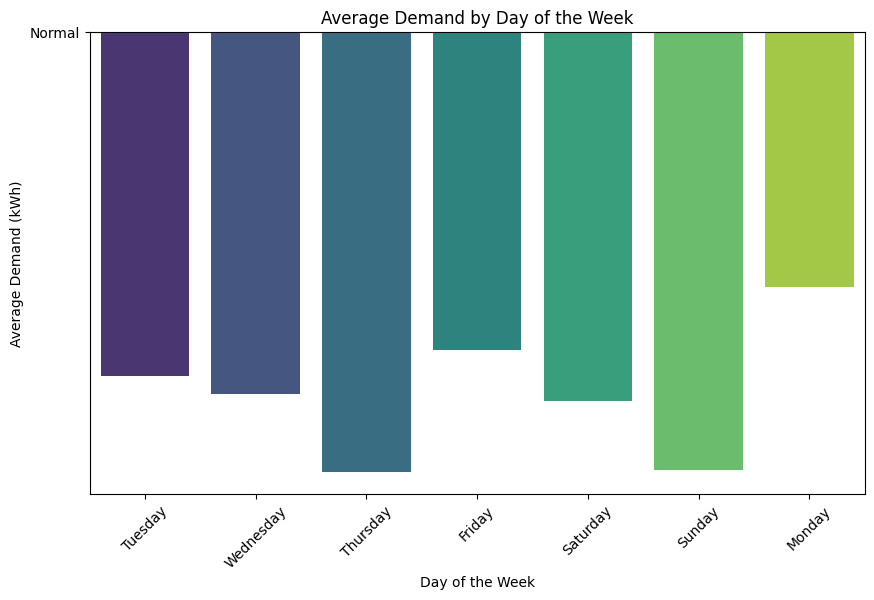

In [ ]:
# ---- Demand by Day of the Week ----
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeek', y='Demand', data=demand, estimator='mean', ci=None, palette='viridis')
plt.title('Average Demand by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Demand (kWh)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Based on the bar chart displaying the average demand by day of the week, it is observed that the normal demand tends to be higher on weekends, especially on Sunday. This could be indicative of increased energy consumption during weekends, possibly due to people being at home and engaging in various activities that require electricity. On the other hand, the average demand is more evenly distributed throughout the week, with a slight uptick on Friday. This pattern suggests that while weekends see higher normal demand levels, the overall average demand remains relatively consistent during weekdays. The distinction between normal and average demand levels, as indicated by the color differentiation in the chart, provides a clear visual representation of the varying energy consumption patterns across different days of the week.

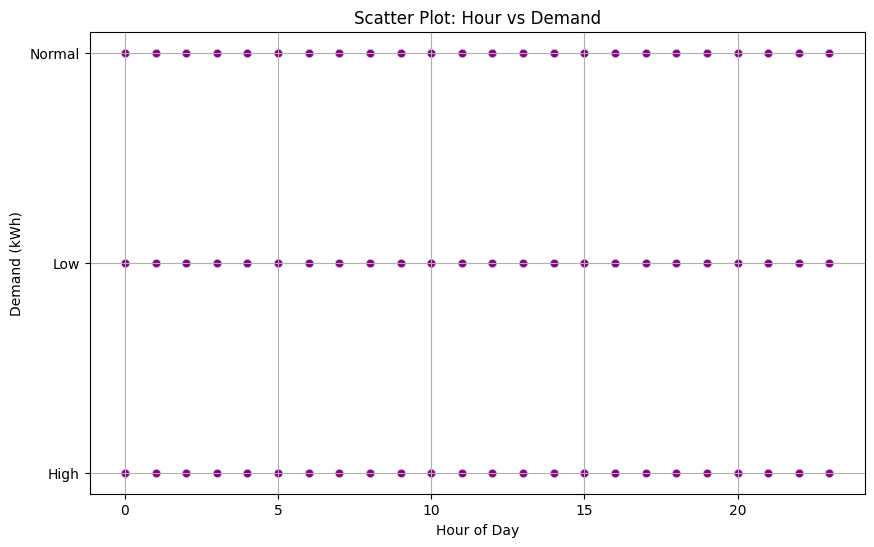

In [ ]:
# ---- Scatter Plot for Hour vs Demand ----
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Hour', y='Demand', data=demand, alpha=0.5, color='purple')
plt.title('Scatter Plot: Hour vs Demand')
plt.xlabel('Hour of Day')
plt.ylabel('Demand (kWh)')
plt.grid()
plt.show()

Based on the scatter plot showing the normal, low, and high demand levels across different hours of the day, it is evident that the normal demand peaks around midday, indicating a typical pattern of higher energy consumption during daytime hours. The low and high demand levels are more evenly distributed across the hours, suggesting that demand variability is not as pronounced during different times of the day. This visualization provides valuable insights into the fluctuation of demand levels throughout the day and can be utilized for energy management and resource allocation strategies.

# **Energy Consumption**

---



## [1]  Data Exploration and Analysis (EDA)

---



### a. Data Cleaning and Preparation

---



In [ ]:

                               ############## Data Connection #############
import os

folder_path = "/content/drive/MyDrive/Colab Notebooks/Carerha DataScience/Assignments/Final Project 1/Final Project"

# List to hold each DataFrame
dataframes = []

# Iterate over each csv file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        # Append to list
        dataframes.append(df)

# Concatenate all dataframes, aligning columns where possible
energy = pd.concat(dataframes, ignore_index=True, sort=False)
energy.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,"00:00:00 13,01,01",0.219,A,A
1,MAC000002,"00:30:00 13,01,01",0.241,A,A
2,MAC000002,"01:00:00 13,01,01",0.191,A,A
3,MAC000002,"01:30:00 13,01,01",0.235,A,A
4,MAC000002,"02:00:00 13,01,01",0.182,A,A


In [ ]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   cell_id                  1380252 non-null  object 
 1   DateTime                 1380252 non-null  object 
 2   KWH/hh (per half hour)   1380252 non-null  float64
 3   site_id                  1380252 non-null  object 
 4   region                   1380252 non-null  object 
dtypes: float64(1), object(4)
memory usage: 52.7+ MB


The data type is not represented well "DateTime" so need to change or transform and there is no null values.

In [ ]:
# Handling Missing Values
print("\nMissing Values Summary:")
print(energy.isnull().sum())


Missing Values Summary:
cell_id                    0
DateTime                   0
KWH/hh (per half hour)     0
site_id                    0
region                     0
dtype: int64


### b- Feature Extraction

---



In [ ]:
                            ######## Data Transformation #########
# Transfrom "DateTime" column into datatime type
energy["DateTime"] = pd.to_datetime(energy["DateTime"],format='%H:%M:%S %y,%d,%m', errors='coerce')
energy['Date'] = pd.to_datetime(energy['DateTime']).dt.date
energy['Time'] = pd.to_datetime(energy['DateTime']).dt.time

# Extract additional time-based features
energy['Hour'] = pd.to_datetime(energy['Time'], format='%H:%M:%S').dt.hour
energy['Month'] = pd.to_datetime(energy['Date'], format='%y/%d/%m').dt.month
energy['DayOfWeek'] = pd.to_datetime(energy['Date'], format='%y/%d/%m').dt.day_name()

# Extract time of day categories
energy['TimeOfDay'] = pd.cut(energy['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)

#Extract weekend or weekday
energy['DayType'] = energy['DayOfWeek'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
energy.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday


In [ ]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   cell_id                  1380252 non-null  object        
 1   DateTime                 1380252 non-null  datetime64[ns]
 2   KWH/hh (per half hour)   1380252 non-null  float64       
 3   site_id                  1380252 non-null  object        
 4   region                   1380252 non-null  object        
 5   Date                     1380252 non-null  object        
 6   Time                     1380252 non-null  object        
 7   Hour                     1380252 non-null  int32         
 8   Month                    1380252 non-null  int32         
 9   DayOfWeek                1380252 non-null  object        
 10  TimeOfDay                1380252 non-null  category      
 11  DayType                  1380252 non-null  object        
dtype

### c- Exploratory Analysis

---



In [ ]:
energy.describe()

,DateTime,KWH/hh (per half hour),Hour,Month
count,1380252,1.380252e+06,1.380252e+06,1.380252e+06
mean,2013-06-29 15:34:13.513706240,2.423353e-01,1.149191e+01,6.433273e+00
min,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2013-03-30 12:30:00,6.500000e-02,5.000000e+00,3.000000e+00
50%,2013-06-28 12:00:00,1.360000e-01,1.100000e+01,6.000000e+00
75%,2013-09-27 15:00:00,2.650000e-01,1.700000e+01,9.000000e+00
max,2013-12-31 23:30:00,7.657000e+03,2.300000e+01,1.200000e+01
std,NaN,6.765435e+00,6.926504e+00,3.437180e+00


**1. Data Collection Period and Frequency:**

**DateTime:**

min: The earliest recorded datetime is January 1st, 2013, at 00:00:00.
max: The latest recorded datetime is December 31st, 2013, at 23:30:00.

Conclusion: The data likely spans a full year of 2013, collected at half-hourly intervals.

**Hour:**

min: 0
max: 23

Conclusion: Data likely collected at half-hourly intervals, as there are 48 half-hour periods in a day (0:00, 0:30, 1:00, and so on).

**Month:**

min: 1 (January)
max: 12 (December)

Conclusion: Reinforces that data covers all months of the year.

**2. Energy Consumption (KWH/hh):**

mean: The average energy consumption per half hour is approximately 0.242 KWH/hh.
min: The minimum consumption is 0 KWH/hh, indicating periods of no energy usage.
max: The maximum consumption is a very high value (7657 KWH/hh), which could be an outlier or indicate a significant event. It's worth investigating this further.
std: The standard deviation is relatively high, suggesting significant variability in energy consumption.

**3. Temporal Patterns:**

**Hour:**
mean: The average hour of data collection is around noon (11.5).

Conclusion: This suggests relatively even data distribution throughout the day.

**Month:**
mean: The average month is close to July (6.5).

Conclusion: Aligns with the 'DateTime' mean, indicating a balanced distribution across months.

**4. Data Distribution:**

**DateTime:**
25% (first quartile): 25% of the datetime values are before March 12th, 2013, at 23:00:00.
75% (third quartile): 75% of the datetime values are before September 12th, 2013, at 23:00:00.

Conclusion: A fairly even distribution of data points across the year.

**Hour:**
std: 6.922

Conclusion: Moderate spread of data across hours of the day.

**Month:**
std: 3.452

Conclusion: Data is fairly evenly distributed across months.

**5. Potential Outliers and Anomalies:**

The **very high max value for 'KWH/hh'** warrants further investigation as it might be an **outlier or an anomaly**.

**Overall Insights:**

The 'energy' dataset covers a full year (2013) of energy consumption data, collected at half-hourly intervals.
The data is generally **evenly distributed** across hours of the day and months of the year.
There is significant variability in energy consumption, indicated by the **high standard deviation**.

The very high maximum consumption value needs further investigation.
Further analysis and visualization are recommended to gain deeper insights into energy consumption patterns and potential anomalies.

In [ ]:
print('KWH/hh (per half hour)' in energy.columns)

False


In [ ]:
print(energy.columns)

Index(['cell_id', 'DateTime', 'KWH/hh (per half hour) ', 'site_id', 'region',
       'Date', 'Time', 'Hour', 'Month', 'DayOfWeek', 'TimeOfDay', 'DayType'],
      dtype='object')


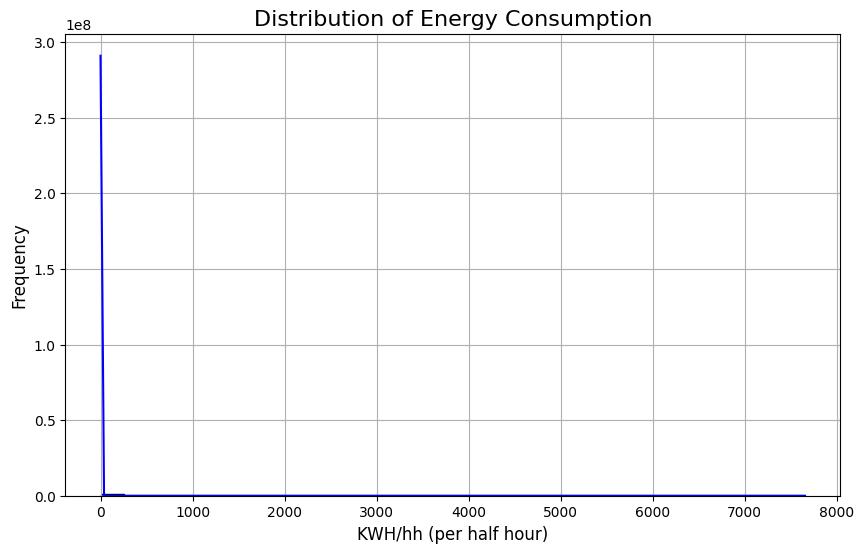

In [ ]:
# 1. **Distribution of Energy Consumption (Histogram)**
plt.figure(figsize=(10, 6))
sns.histplot(energy['KWH/hh (per half hour) '], kde=True, bins=30, color='blue')
plt.title('Distribution of Energy Consumption', fontsize=16)
plt.xlabel('KWH/hh (per half hour)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

Observations:

Highly Skewed Distribution:

The majority of the values are clustered near zero, indicating that most energy consumption values are relatively low.
A few extreme values (outliers) extend to very high consumption levels, creating a long tail to the right.

Outliers:

The high energy consumption values (above 1000 KWH per half hour) are likely outliers. These could be caused by errors in data collection or genuinely high consumption sites (e.g., industrial or commercial sites).
The presence of these outliers makes the histogram difficult to interpret in terms of normal energy consumption patterns.

Need for Scaling or Transformation:

To better understand the distribution of the majority of the data, applying a logarithmic transformation to the data might help compress the range of the outliers and provide a clearer picture of typical energy consumption values.

<ipython-input-26-b5cc7d9228dd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='KWH/hh (per half hour) ', data=energy, palette='Set3')


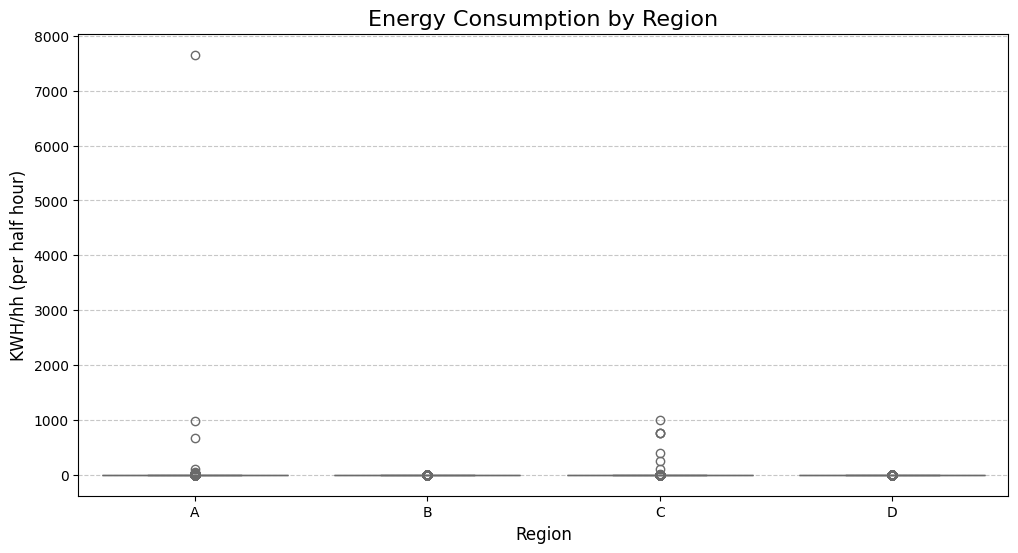

In [ ]:
# --- 2. Box Plot by Region ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='KWH/hh (per half hour) ', data=energy, palette='Set3')
plt.title('Energy Consumption by Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('KWH/hh (per half hour)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Observations:

Low Median Consumption Across All Regions:

Most of the energy consumption values in regions A, B, C, and D are clustered near zero, indicating that typical consumption levels are generally low in all regions.

Presence of Outliers:

Significant outliers are visible in all regions, but their frequency and magnitude differ:
* Region A and Region C have the most pronounced outliers, with a few data points showing very high energy consumption.
* Regions B and D have fewer visible outliers, suggesting more consistent energy usage patterns in these regions.

Similar Patterns Across Regions:

The interquartile range (IQR) for all regions is very narrow, indicating that the central 50% of energy consumption values do not vary significantly between regions.

Region-Specific Anomalies:

The higher number of extreme outliers in Region A and Region C could indicate that these regions have specific sites with exceptionally high energy demands (e.g., industrial or commercial establishments).

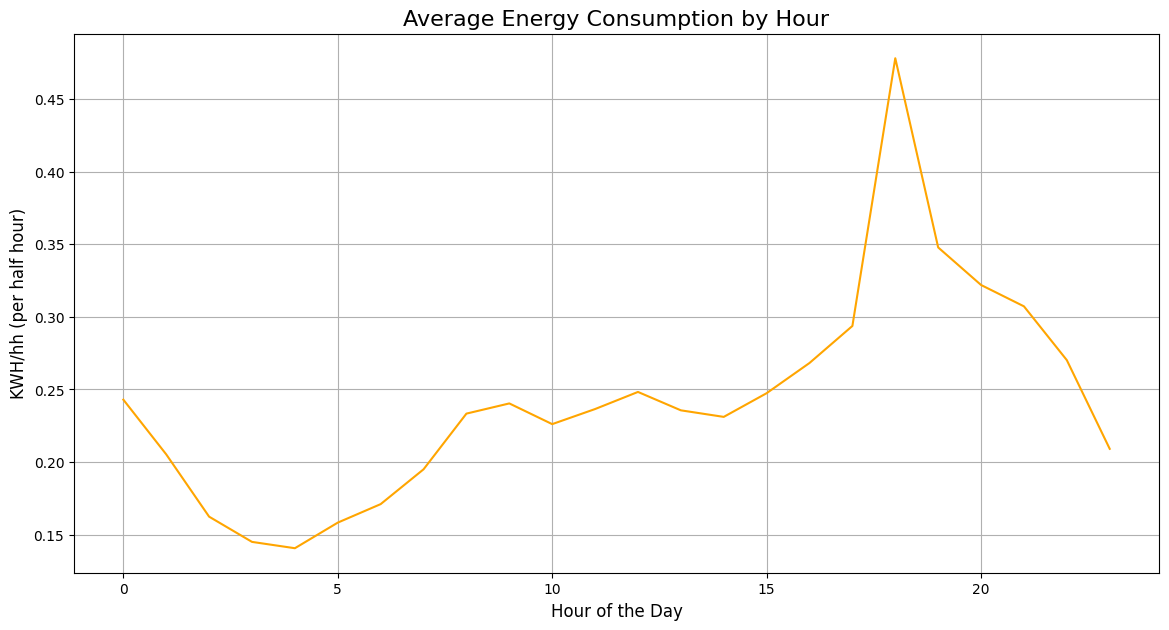

In [ ]:
# 3. **Time-Series Analysis (Line Plot)**
plt.figure(figsize=(14, 7))
hourly_data = energy.groupby(['Hour'])['KWH/hh (per half hour) '].mean().reset_index()
sns.lineplot(data=hourly_data, x='Hour', y='KWH/hh (per half hour) ', color='orange')
plt.title('Average Energy Consumption by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('KWH/hh (per half hour)', fontsize=12)
plt.grid(True)
plt.show()

Based on the analysis of the image provided, it can be concluded that the average energy consumption by hour follows a specific pattern throughout the day. The energy consumption is lowest at the beginning of the day, gradually increases, peaks sharply in the evening, and then decreases towards the end of the day. This pattern is indicative of typical household or industrial electricity usage, with higher consumption during evening hours when appliances and lighting are more commonly used.

The sharp peak in energy consumption during the evening suggests a significant increase in demand, possibly due to increased usage of electrical devices or heating systems during that time. This insight can be valuable for energy providers and consumers in understanding when the peak demand occurs and how it relates to pricing strategies. By analyzing these patterns, energy-saving measures can be planned effectively, and the impact of demand pricing on consumer behavior can be better understood.

<ipython-input-28-c1afbb0e8b86>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_type_avg, x='DayType', y='KWH/hh (per half hour) ', palette='coolwarm')


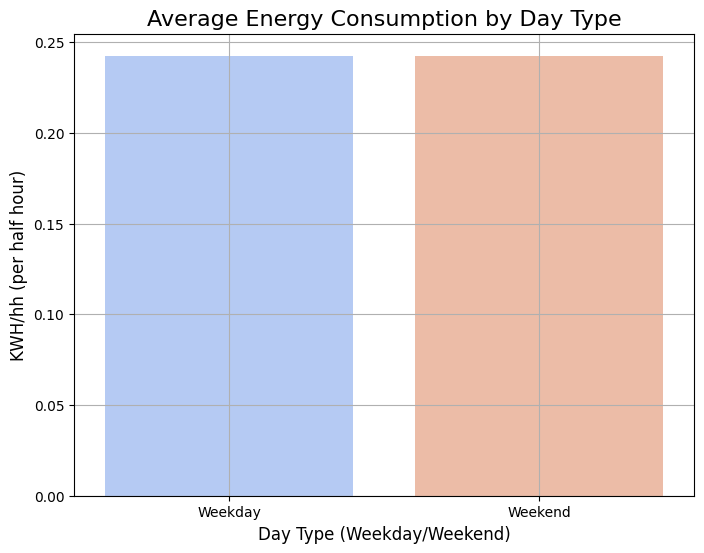

In [ ]:
# 4. **Bar Plot of Day Type (Weekday vs Weekend)**
plt.figure(figsize=(8, 6))
day_type_avg = energy.groupby('DayType')['KWH/hh (per half hour) '].mean().reset_index()
sns.barplot(data=day_type_avg, x='DayType', y='KWH/hh (per half hour) ', palette='coolwarm')
plt.title('Average Energy Consumption by Day Type', fontsize=16)
plt.xlabel('Day Type (Weekday/Weekend)', fontsize=12)
plt.ylabel('KWH/hh (per half hour)', fontsize=12)
plt.grid(True)
plt.show()

Based on the analysis of the image, it can be concluded that the average energy consumption per half hour is similar on both weekdays and weekends. The average energy consumption during both weekdays and weekends is around 0.20 KWH/h per half hour, indicating that there is no significant difference in energy usage patterns between these two types of days. This suggests that energy consumption remains relatively consistent regardless of whether it is a weekday or a weekend. Understanding this consistent pattern of energy usage can be valuable for planning energy-saving measures and policies that can be applied consistently throughout the week to optimize energy efficiency.

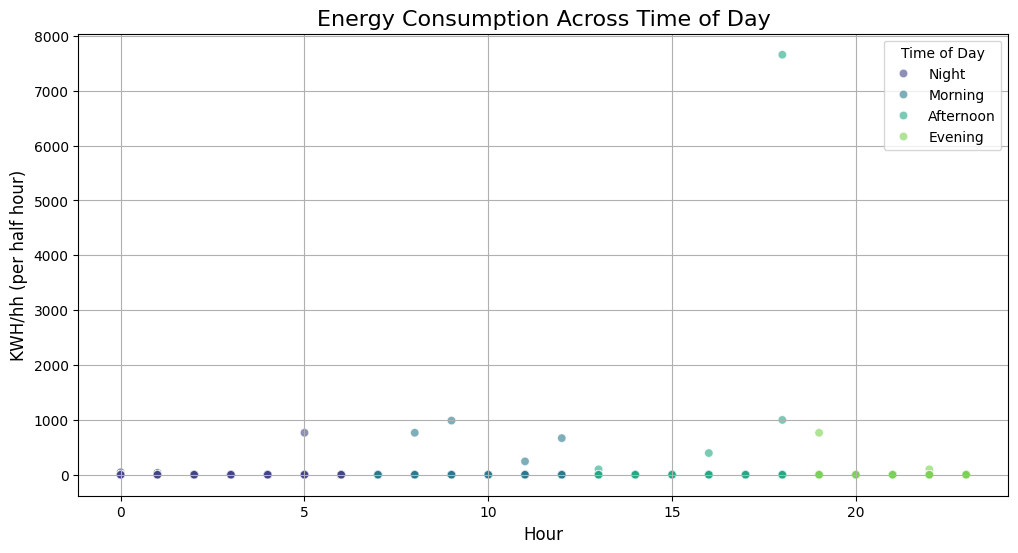

In [ ]:
# 5. **Scatter Plot of Consumption vs Time of Day**
plt.figure(figsize=(12, 6))
sns.scatterplot(data=energy, x='Hour', y='KWH/hh (per half hour) ', hue='TimeOfDay', alpha=0.6, palette='viridis')
plt.title('Energy Consumption Across Time of Day', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('KWH/hh (per half hour)', fontsize=12)
plt.legend(title='Time of Day')
plt.grid(True)
plt.show()

Based on the analysis of the graph titled "Energy Consumption Across Time of Day," it can be concluded that there are distinct patterns in energy consumption based on the time of day. The graph shows that energy consumption is lowest during the night, gradually increases during the morning, peaks during the afternoon, and then decreases towards the evening. The highest energy consumption is observed during the afternoon, while the lowest energy consumption is observed during the night.

Additionally, the graph indicates that there is a consistent average energy consumption per half hour, with values remaining around 0.20 KWH/h on both weekdays and weekends. This suggests that energy usage patterns do not vary significantly between weekdays and weekends.

Understanding these patterns can be valuable for energy planning and management, as it highlights the times of day when energy demand is highest and lowest. This information can help in optimizing energy distribution, implementing demand response strategies, and promoting energy efficiency measures during peak consumption periods.

<ipython-input-30-35435d0f02a9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_data, x='Month', y='KWH/hh (per half hour) ', palette='Set2')


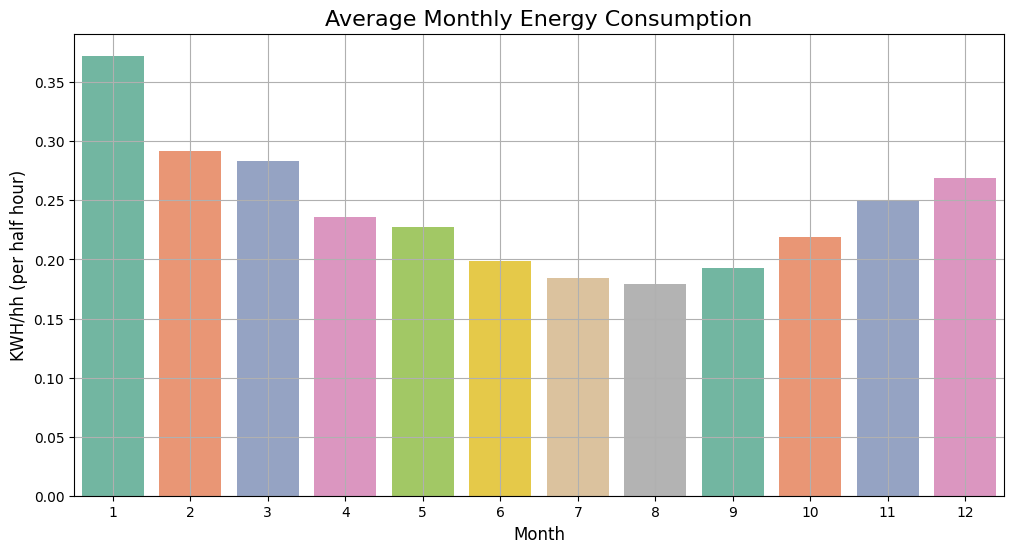

In [ ]:
# 6. **Monthly Trends**
plt.figure(figsize=(12, 6))
monthly_data = energy.groupby(['Month'])['KWH/hh (per half hour) '].mean().reset_index()
sns.barplot(data=monthly_data, x='Month', y='KWH/hh (per half hour) ', palette='Set2')
plt.title('Average Monthly Energy Consumption', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('KWH/hh (per half hour)', fontsize=12)
plt.grid(True)
plt.show()

Based on the information in the image, it can be observed that there are fluctuations in average energy consumption throughout the year. Some months exhibit higher energy consumption levels compared to others. These variations in energy consumption may be influenced by seasonal factors, changes in weather patterns, holidays, or other external factors that affect energy usage patterns. Understanding these fluctuations can help in planning and optimizing energy resources, implementing energy efficiency measures, and managing demand effectively to ensure a reliable and sustainable energy supply throughout the year.

<ipython-input-31-bd82f3f0d4b5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=energy, x='DayOfWeek', y='KWH/hh (per half hour) ', palette='Set1')


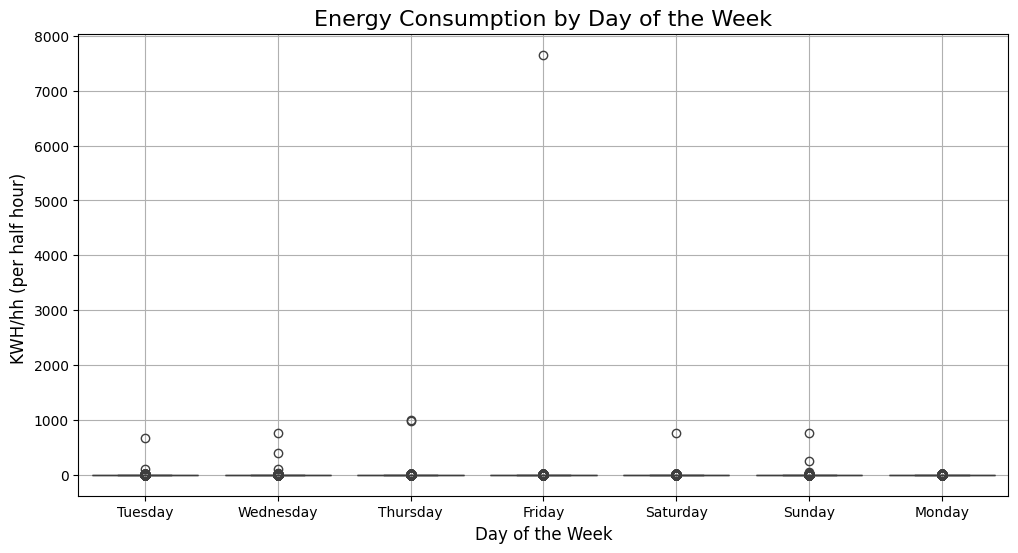

In [ ]:
# 7. **Box Plot by Day of the Week**
plt.figure(figsize=(12, 6))
sns.boxplot(data=energy, x='DayOfWeek', y='KWH/hh (per half hour) ', palette='Set1')
plt.title('Energy Consumption by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('KWH/hh (per half hour) ', fontsize=12)
plt.grid(True)
plt.show()

Based on the information provided in the analysis of the image, it can be inferred that the graph illustrates a consistent energy consumption pattern throughout the week, with a slight increase in usage observed during the weekend. This indicates that energy consumption remains relatively stable across different days of the week, with a minor fluctuation occurring specifically during weekends when consumption slightly rises.

Understanding this trend of consistent energy consumption with a slight peak on weekends can be beneficial for energy planning and management. It suggests that overall energy demand follows a predictable pattern, with higher usage likely associated with increased activities or behaviors during weekends. This insight can help in developing strategies to optimize energy distribution, implement energy-saving measures effectively, and manage demand efficiently to ensure a sustainable and reliable energy supply.

# Merge

---



In [ ]:
# Merge energy and demand based on DateTime
data = pd.merge(energy, demand, on='DateTime', how='inner')
data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Date_x,Time_x,Hour_x,Month_x,DayOfWeek_x,...,DayType_x,Demand,Date_y,Time_y,Hour_y,Month_y,DayOfWeek_y,TimeOfDay_y,DayType_y,CostDemand
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,2013-01-01,00:00:00,0,1,Tuesday,...,Weekday,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday,19.46
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,2013-01-01,00:30:00,0,1,Tuesday,...,Weekday,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday,19.46
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,2013-01-01,01:00:00,1,1,Tuesday,...,Weekday,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday,19.46
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,2013-01-01,01:30:00,1,1,Tuesday,...,Weekday,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday,19.46
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,2013-01-01,02:00:00,2,1,Tuesday,...,Weekday,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday,19.46


In [ ]:
data = data.drop(['Date_x', "Time_x","Hour_x", "Month_x", "DayOfWeek_x", "DayType_x", "TimeOfDay_x" ], axis = 1)
data = data.rename(columns={'Date_y': 'Date', 'Time_y': 'Time', 'Hour_y': 'Hour', 'Month_y': 'Month', 'DayOfWeek_y': 'DayOfWeek', 'DayType_y': 'DayType', "TimeOfDay_y": "TimeOfDay"})
data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday,19.46
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday,19.46
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday,19.46
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday,19.46
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday,19.46


In [ ]:
data['EGPCost'] = (data['KWH/hh (per half hour) ']/100) * data['CostDemand']
data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday,19.46,0.042617
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday,19.46,0.046899
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday,19.46,0.037169
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday,19.46,0.045731
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday,19.46,0.035417


<Axes: xlabel='DateTime', ylabel='EGPCost'>

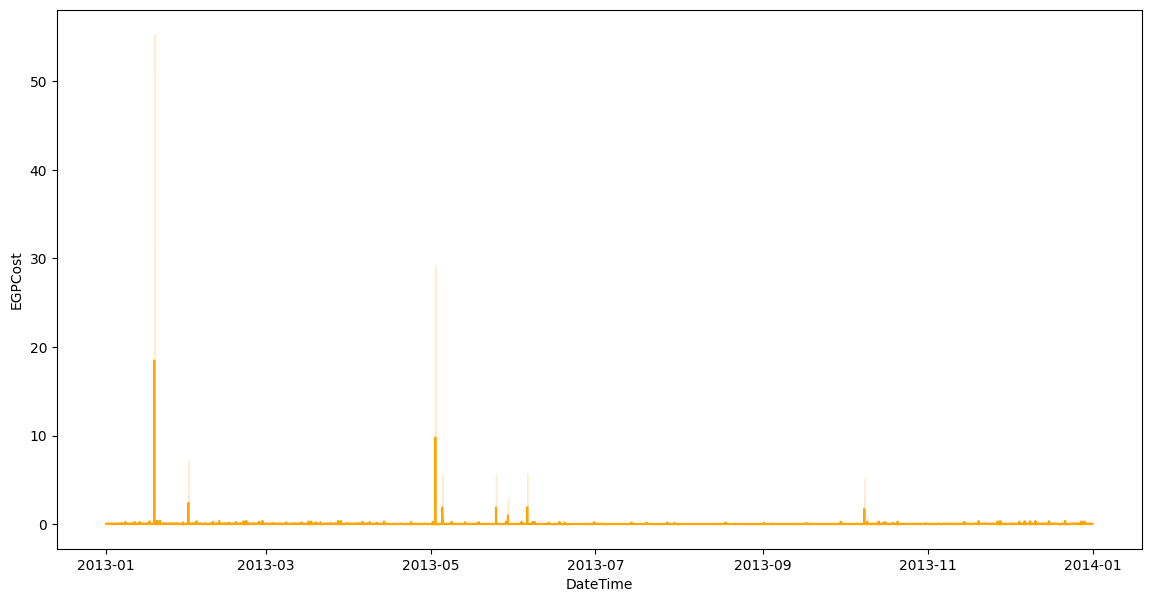

In [ ]:
# line plot to egycost
plt.figure(figsize=(14, 7))
sns.lineplot(data=data, x='DateTime', y='EGPCost', color='orange')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   cell_id                  1380252 non-null  object        
 1   DateTime                 1380252 non-null  datetime64[ns]
 2   KWH/hh (per half hour)   1380252 non-null  float64       
 3   site_id                  1380252 non-null  object        
 4   region                   1380252 non-null  object        
 5   Demand                   1380252 non-null  object        
 6   Date                     1380252 non-null  object        
 7   Time                     1380252 non-null  object        
 8   Hour                     1380252 non-null  int32         
 9   Month                    1380252 non-null  int32         
 10  DayOfWeek                1380252 non-null  object        
 11  TimeOfDay                1380252 non-null  category      
 12  

In [ ]:
data.isna( ).sum()

,0
cell_id,0
DateTime,0
KWH/hh (per half hour),0
site_id,0
region,0
Demand,0
Date,0
Time,0
Hour,0
Month,0


In [ ]:
# Calculate each cell_id counts during 24 hr everyday to see the cell_id that's less than 17520
cell_counts = data['cell_id'].value_counts()

# Get cell_ids with counts less than 17520
cell_ids_less_than_17520 = cell_counts[cell_counts < 17520].index
len(cell_ids_less_than_17520)

13

In [ ]:
data = data[data['cell_id'].isin(cell_ids_less_than_17520)]
data

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost
87654,MAC000008,2013-01-01 00:00:00,0.244,H,C,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday,19.46,0.047482
87655,MAC000008,2013-01-01 00:30:00,0.245,H,C,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday,19.46,0.047677
87656,MAC000008,2013-01-01 01:00:00,0.263,H,C,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday,19.46,0.051180
87657,MAC000008,2013-01-01 01:30:00,0.261,H,C,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday,19.46,0.050791
87658,MAC000008,2013-01-01 02:00:00,0.255,H,C,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday,19.46,0.049623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321330,MAC000063,2013-09-23 21:30:00,0.552,D,A,Normal,2013-09-23,21:30:00,21,9,Monday,Evening,Weekday,19.46,0.107419
1321331,MAC000063,2013-09-23 22:00:00,0.491,D,A,Normal,2013-09-23,22:00:00,22,9,Monday,Evening,Weekday,19.46,0.095549
1321332,MAC000063,2013-09-23 22:30:00,0.426,D,A,Normal,2013-09-23,22:30:00,22,9,Monday,Evening,Weekday,19.46,0.082900
1321333,MAC000063,2013-09-23 23:00:00,0.605,D,A,Normal,2013-09-23,23:00:00,23,9,Monday,Evening,Weekday,19.46,0.117733


In [ ]:
data.duplicated().sum()

114

In [ ]:
data[data.duplicated()]

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost
88615,MAC000008,2013-01-21,0.636,H,C,Low,2013-01-21,00:00:00,0,1,Monday,Night,Weekday,6.89,0.043820
90104,MAC000008,2013-02-21,0.290,H,C,Low,2013-02-21,00:00:00,0,2,Thursday,Night,Weekday,6.89,0.019981
91593,MAC000008,2013-03-24,0.351,H,C,Normal,2013-03-24,00:00:00,0,3,Sunday,Night,Weekend,19.46,0.068305
93082,MAC000008,2013-04-24,0.333,H,C,Low,2013-04-24,00:00:00,0,4,Wednesday,Night,Weekday,6.89,0.022944
94571,MAC000008,2013-05-25,0.168,H,C,Normal,2013-05-25,00:00:00,0,5,Saturday,Night,Weekend,19.46,0.032693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313988,MAC000063,2013-04-24,0.090,D,A,Low,2013-04-24,00:00:00,0,4,Wednesday,Night,Weekday,6.89,0.006201
1315477,MAC000063,2013-05-25,0.153,D,A,Normal,2013-05-25,00:00:00,0,5,Saturday,Night,Weekend,19.46,0.029774
1316965,MAC000063,2013-06-25,0.566,D,A,Normal,2013-06-25,00:00:00,0,6,Tuesday,Night,Weekday,19.46,0.110144
1318454,MAC000063,2013-07-26,0.086,D,A,Normal,2013-07-26,00:00:00,0,7,Friday,Night,Weekday,19.46,0.016736


In [ ]:
# Delete duplicate
data = data.drop_duplicates()
data.duplicated().sum()

0

In [ ]:
data.describe()

,DateTime,KWH/hh (per half hour),Hour,Month,CostDemand,EGPCost
count,170589,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000
mean,2013-06-09 11:36:57.540404224,0.210328,11.498678,5.776422,20.858311,0.045022
min,2013-01-01 00:00:00,0.000000,0.000000,1.000000,6.890000,0.000000
25%,2013-03-14 21:30:00,0.070000,5.000000,3.000000,19.460000,0.011920
50%,2013-05-31 23:00:00,0.133000,11.000000,5.000000,19.460000,0.025103
75%,2013-08-29 19:30:00,0.245000,17.000000,8.000000,19.460000,0.048261
max,2013-12-31 23:30:00,4.040000,23.000000,12.000000,77.210000,2.283100
std,NaN,0.254919,6.922669,3.286380,12.641074,0.076237


## [2] Threshold Recommendation and Cost Savings

---



In [ ]:
# IQR
Q1 = data['KWH/hh (per half hour) '].quantile(0.25)
Q3 = data['KWH/hh (per half hour) '].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data["AD_KWH/hh (per half hour) "] = np.where((data['KWH/hh (per half hour) '] < lower_bound) | (data['KWH/hh (per half hour) '] > upper_bound), 1, 0)
data[data["AD_KWH/hh (per half hour) "] == 1]

<ipython-input-104-bbc11660e0a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["AD_KWH/hh (per half hour) "] = np.where((data['KWH/hh (per half hour) '] < lower_bound) | (data['KWH/hh (per half hour) '] > upper_bound), 1, 0)


,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost,AD_KWH/hh (per half hour)
87733,MAC000008,2013-01-02 15:30:00,0.752,H,C,Normal,2013-01-02,15:30:00,15,1,Wednesday,Afternoon,Weekday,19.46,0.146339,1
87734,MAC000008,2013-01-02 16:00:00,1.331,H,C,Normal,2013-01-02,16:00:00,16,1,Wednesday,Afternoon,Weekday,19.46,0.259013,1
87735,MAC000008,2013-01-02 16:30:00,0.650,H,C,Normal,2013-01-02,16:30:00,16,1,Wednesday,Afternoon,Weekday,19.46,0.126490,1
87739,MAC000008,2013-01-02 18:30:00,0.525,H,C,Normal,2013-01-02,18:30:00,18,1,Wednesday,Afternoon,Weekday,19.46,0.102165,1
87741,MAC000008,2013-01-02 19:30:00,0.518,H,C,Normal,2013-01-02,19:30:00,19,1,Wednesday,Evening,Weekday,19.46,0.100803,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321154,MAC000063,2013-09-20 05:30:00,0.654,D,A,Normal,2013-09-20,05:30:00,5,9,Friday,Night,Weekday,19.46,0.127268,1
1321159,MAC000063,2013-09-20 08:00:00,0.574,D,A,Normal,2013-09-20,08:00:00,8,9,Friday,Morning,Weekday,19.46,0.111700,1
1321329,MAC000063,2013-09-23 21:00:00,0.630,D,A,Normal,2013-09-23,21:00:00,21,9,Monday,Evening,Weekday,19.46,0.122598,1
1321330,MAC000063,2013-09-23 21:30:00,0.552,D,A,Normal,2013-09-23,21:30:00,21,9,Monday,Evening,Weekday,19.46,0.107419,1


too many AD

In [ ]:
def remove_cols_containing_ad(df):
  """Removes columns containing 'AD_' from a DataFrame.

  Args:
    df: pandas DataFrame.

  Returns:
    DataFrame with columns containing 'AD_' removed.
  """
  cols_to_remove = [col for col in df.columns if 'AD_' in col]
  df = df.drop(columns=cols_to_remove)
  return df

In [ ]:
# Remove the AD columns
data = remove_cols_containing_ad(data)
data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost
87654,MAC000008,2013-01-01 00:00:00,0.244,H,C,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday,19.46,0.047482
87655,MAC000008,2013-01-01 00:30:00,0.245,H,C,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday,19.46,0.047677
87656,MAC000008,2013-01-01 01:00:00,0.263,H,C,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday,19.46,0.051180
87657,MAC000008,2013-01-01 01:30:00,0.261,H,C,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday,19.46,0.050791
87658,MAC000008,2013-01-01 02:00:00,0.255,H,C,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday,19.46,0.049623


In [ ]:
# MAD
KWH_median = np.median(data['KWH/hh (per half hour) '])
KWH_mad = np.median(np.abs(data['KWH/hh (per half hour) '] - KWH_median))
MAD = np.median(KWH_mad)
threshold = MAD * 4

In [ ]:
data['MAD_KWH/hh (per half hour) '] = np.where(data['KWH/hh (per half hour) ']> threshold, 1, 0)
data[data["MAD_KWH/hh (per half hour) "] == 1]

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost,MAD_KWH/hh (per half hour)
87662,MAC000008,2013-01-01 04:00:00,0.321,H,C,Normal,2013-01-01,04:00:00,4,1,Tuesday,Night,Weekday,19.46,0.062467,1
87663,MAC000008,2013-01-01 04:30:00,0.319,H,C,Normal,2013-01-01,04:30:00,4,1,Tuesday,Night,Weekday,19.46,0.062077,1
87674,MAC000008,2013-01-01 10:00:00,0.354,H,C,Normal,2013-01-01,10:00:00,10,1,Tuesday,Morning,Weekday,19.46,0.068888,1
87729,MAC000008,2013-01-02 13:30:00,0.310,H,C,Normal,2013-01-02,13:30:00,13,1,Wednesday,Afternoon,Weekday,19.46,0.060326,1
87732,MAC000008,2013-01-02 15:00:00,0.348,H,C,Normal,2013-01-02,15:00:00,15,1,Wednesday,Afternoon,Weekday,19.46,0.067721,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321329,MAC000063,2013-09-23 21:00:00,0.630,D,A,Normal,2013-09-23,21:00:00,21,9,Monday,Evening,Weekday,19.46,0.122598,1
1321330,MAC000063,2013-09-23 21:30:00,0.552,D,A,Normal,2013-09-23,21:30:00,21,9,Monday,Evening,Weekday,19.46,0.107419,1
1321331,MAC000063,2013-09-23 22:00:00,0.491,D,A,Normal,2013-09-23,22:00:00,22,9,Monday,Evening,Weekday,19.46,0.095549,1
1321332,MAC000063,2013-09-23 22:30:00,0.426,D,A,Normal,2013-09-23,22:30:00,22,9,Monday,Evening,Weekday,19.46,0.082900,1


In [ ]:
! pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=ea673ab1427dc8f3b13bff61b650172ee8933205c65c5fdee29796d6830044b3
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
# Multivariate Anomaly Detection
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler

# Choose Cols/Features Needed
features = ['KWH/hh (per half hour) ', 'EGPCost']

# # Normalize the featreus
# scaler = StandardScaler()
# data[features] = scaler.fit_transform(data[features])

# Anomaly detection
data['AD_ABOD'] = ABOD().fit(data[features]).labels_
data['AD_KNN'] = KNN().fit(data[features]).labels_
data['AD_LOF'] = LOF().fit(data[features]).labels_
data['AD_IForest'] = IForest().fit(data[features]).labels_

data['AD_Final_Result'] = data[['AD_ABOD','AD_KNN', 'AD_LOF', 'AD_IForest']].sum(axis = 1)
data['AD_Final_Result'] = np.where(data['AD_Final_Result'] >= 2, 1, 0)

data.head()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,...,TimeOfDay,DayType,CostDemand,EGPCost,MAD_KWH/hh (per half hour),AD_ABOD,AD_KNN,AD_LOF,AD_IForest,AD_Final_Result
87654,MAC000008,2013-01-01 00:00:00,0.244,H,C,Normal,2013-01-01,00:00:00,0,1,...,Night,Weekday,19.46,0.047482,0,0,0,0,0,0
87655,MAC000008,2013-01-01 00:30:00,0.245,H,C,Normal,2013-01-01,00:30:00,0,1,...,Night,Weekday,19.46,0.047677,0,0,0,0,0,0
87656,MAC000008,2013-01-01 01:00:00,0.263,H,C,Normal,2013-01-01,01:00:00,1,1,...,Night,Weekday,19.46,0.051180,0,0,0,0,0,0
87657,MAC000008,2013-01-01 01:30:00,0.261,H,C,Normal,2013-01-01,01:30:00,1,1,...,Night,Weekday,19.46,0.050791,0,0,0,0,0,0
87658,MAC000008,2013-01-01 02:00:00,0.255,H,C,Normal,2013-01-01,02:00:00,2,1,...,Night,Weekday,19.46,0.049623,0,0,0,0,0,0


In [ ]:
data[data["AD_Final_Result"]==1]

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,...,TimeOfDay,DayType,CostDemand,EGPCost,MAD_KWH/hh (per half hour),AD_ABOD,AD_KNN,AD_LOF,AD_IForest,AD_Final_Result
87734,MAC000008,2013-01-02 16:00:00,1.331,H,C,Normal,2013-01-02,16:00:00,16,1,...,Afternoon,Weekday,19.46,0.259013,1,0,1,0,1,1
87770,MAC000008,2013-01-03 10:00:00,1.298,H,C,Normal,2013-01-03,10:00:00,10,1,...,Morning,Weekday,19.46,0.252591,1,0,1,1,1,1
87774,MAC000008,2013-01-03 12:00:00,0.921,H,C,Normal,2013-01-03,12:00:00,12,1,...,Morning,Weekday,19.46,0.179227,1,0,0,1,1,1
87796,MAC000008,2013-01-03 23:00:00,0.948,H,C,Normal,2013-01-03,23:00:00,23,1,...,Evening,Weekday,19.46,0.184481,1,0,0,1,1,1
87823,MAC000008,2013-01-04 12:30:00,1.054,H,C,Normal,2013-01-04,12:30:00,12,1,...,Morning,Weekday,19.46,0.205108,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321038,MAC000063,2013-09-17 19:30:00,0.642,D,A,Normal,2013-09-17,19:30:00,19,9,...,Evening,Weekday,19.46,0.124933,1,0,0,1,1,1
1321045,MAC000063,2013-09-17 23:00:00,0.577,D,A,Low,2013-09-17,23:00:00,23,9,...,Evening,Weekday,6.89,0.039755,1,0,1,1,1,1
1321046,MAC000063,2013-09-17 23:30:00,0.519,D,A,Low,2013-09-17,23:30:00,23,9,...,Evening,Weekday,6.89,0.035759,1,0,0,1,1,1
1321047,MAC000063,2013-09-18 00:00:00,0.431,D,A,Low,2013-09-18,00:00:00,0,9,...,Night,Weekday,6.89,0.029696,1,0,0,1,1,1


In [ ]:
data["AD_Final_Result"].value_counts()

,count
AD_Final_Result,
0,163050
1,7539


so I use the final output as way to make treatment based on it

In [ ]:
# drop outliers
data[data['AD_Final_Result'] == 0]

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,...,TimeOfDay,DayType,CostDemand,EGPCost,MAD_KWH/hh (per half hour),AD_ABOD,AD_KNN,AD_LOF,AD_IForest,AD_Final_Result
87654,MAC000008,2013-01-01 00:00:00,0.244,H,C,Normal,2013-01-01,00:00:00,0,1,...,Night,Weekday,19.46,0.047482,0,0,0,0,0,0
87655,MAC000008,2013-01-01 00:30:00,0.245,H,C,Normal,2013-01-01,00:30:00,0,1,...,Night,Weekday,19.46,0.047677,0,0,0,0,0,0
87656,MAC000008,2013-01-01 01:00:00,0.263,H,C,Normal,2013-01-01,01:00:00,1,1,...,Night,Weekday,19.46,0.051180,0,0,0,0,0,0
87657,MAC000008,2013-01-01 01:30:00,0.261,H,C,Normal,2013-01-01,01:30:00,1,1,...,Night,Weekday,19.46,0.050791,0,0,0,0,0,0
87658,MAC000008,2013-01-01 02:00:00,0.255,H,C,Normal,2013-01-01,02:00:00,2,1,...,Night,Weekday,19.46,0.049623,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321330,MAC000063,2013-09-23 21:30:00,0.552,D,A,Normal,2013-09-23,21:30:00,21,9,...,Evening,Weekday,19.46,0.107419,1,0,0,1,0,0
1321331,MAC000063,2013-09-23 22:00:00,0.491,D,A,Normal,2013-09-23,22:00:00,22,9,...,Evening,Weekday,19.46,0.095549,1,0,0,0,0,0
1321332,MAC000063,2013-09-23 22:30:00,0.426,D,A,Normal,2013-09-23,22:30:00,22,9,...,Evening,Weekday,19.46,0.082900,1,0,0,0,0,0
1321333,MAC000063,2013-09-23 23:00:00,0.605,D,A,Normal,2013-09-23,23:00:00,23,9,...,Evening,Weekday,19.46,0.117733,1,0,0,0,1,0


In [ ]:
# Imputation                  # if it's AD = 1 replace by median , others AD= 0 keep it as it is from original column
data['New_Imputed_KWH'] = np.where(data['AD_Final_Result'] == 1, np.median(data['KWH/hh (per half hour) ']), data['KWH/hh (per half hour) '])

data

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,...,DayType,CostDemand,EGPCost,MAD_KWH/hh (per half hour),AD_ABOD,AD_KNN,AD_LOF,AD_IForest,AD_Final_Result,New_Imputed_KWH
87654,MAC000008,2013-01-01 00:00:00,0.244,H,C,Normal,2013-01-01,00:00:00,0,1,...,Weekday,19.46,0.047482,0,0,0,0,0,0,0.244
87655,MAC000008,2013-01-01 00:30:00,0.245,H,C,Normal,2013-01-01,00:30:00,0,1,...,Weekday,19.46,0.047677,0,0,0,0,0,0,0.245
87656,MAC000008,2013-01-01 01:00:00,0.263,H,C,Normal,2013-01-01,01:00:00,1,1,...,Weekday,19.46,0.051180,0,0,0,0,0,0,0.263
87657,MAC000008,2013-01-01 01:30:00,0.261,H,C,Normal,2013-01-01,01:30:00,1,1,...,Weekday,19.46,0.050791,0,0,0,0,0,0,0.261
87658,MAC000008,2013-01-01 02:00:00,0.255,H,C,Normal,2013-01-01,02:00:00,2,1,...,Weekday,19.46,0.049623,0,0,0,0,0,0,0.255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321330,MAC000063,2013-09-23 21:30:00,0.552,D,A,Normal,2013-09-23,21:30:00,21,9,...,Weekday,19.46,0.107419,1,0,0,1,0,0,0.552
1321331,MAC000063,2013-09-23 22:00:00,0.491,D,A,Normal,2013-09-23,22:00:00,22,9,...,Weekday,19.46,0.095549,1,0,0,0,0,0,0.491
1321332,MAC000063,2013-09-23 22:30:00,0.426,D,A,Normal,2013-09-23,22:30:00,22,9,...,Weekday,19.46,0.082900,1,0,0,0,0,0,0.426
1321333,MAC000063,2013-09-23 23:00:00,0.605,D,A,Normal,2013-09-23,23:00:00,23,9,...,Weekday,19.46,0.117733,1,0,0,0,1,0,0.605


In [ ]:
# Log transformation
data['Log_KWH'] = np.log1p(data['KWH/hh (per half hour) '])  # Adding 1 to handle 0 values

In [ ]:
from scipy.stats.mstats import winsorize
# Winsorize the 'KWH/hh (per half hour) ' column at the 5th and 95th percentiles
data['Winsorized_KWH'] = winsorize(data['KWH/hh (per half hour) '], limits=[0.05, 0.05])

In [ ]:
data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,...,EGPCost,MAD_KWH/hh (per half hour),AD_ABOD,AD_KNN,AD_LOF,AD_IForest,AD_Final_Result,New_Imputed_KWH,Log_KWH,Winsorized_KWH
87654,MAC000008,2013-01-01 00:00:00,0.244,H,C,Normal,2013-01-01,00:00:00,0,1,...,0.047482,0,0,0,0,0,0,0.244,0.218332,0.244
87655,MAC000008,2013-01-01 00:30:00,0.245,H,C,Normal,2013-01-01,00:30:00,0,1,...,0.047677,0,0,0,0,0,0,0.245,0.219136,0.245
87656,MAC000008,2013-01-01 01:00:00,0.263,H,C,Normal,2013-01-01,01:00:00,1,1,...,0.051180,0,0,0,0,0,0,0.263,0.233490,0.263
87657,MAC000008,2013-01-01 01:30:00,0.261,H,C,Normal,2013-01-01,01:30:00,1,1,...,0.050791,0,0,0,0,0,0,0.261,0.231905,0.261
87658,MAC000008,2013-01-01 02:00:00,0.255,H,C,Normal,2013-01-01,02:00:00,2,1,...,0.049623,0,0,0,0,0,0,0.255,0.227136,0.255


In [ ]:
# Remove the AD columns
data = remove_cols_containing_ad(data)
data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost,New_Imputed_KWH,Log_KWH,Winsorized_KWH
87654,MAC000008,2013-01-01 00:00:00,0.244,H,C,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday,19.46,0.047482,0.244,0.218332,0.244
87655,MAC000008,2013-01-01 00:30:00,0.245,H,C,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday,19.46,0.047677,0.245,0.219136,0.245
87656,MAC000008,2013-01-01 01:00:00,0.263,H,C,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday,19.46,0.051180,0.263,0.233490,0.263
87657,MAC000008,2013-01-01 01:30:00,0.261,H,C,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday,19.46,0.050791,0.261,0.231905,0.261
87658,MAC000008,2013-01-01 02:00:00,0.255,H,C,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday,19.46,0.049623,0.255,0.227136,0.255


### Assuming that we can shutdown few cells were the consumption is low, what is the threshold that you would recommend and how much KW and EGP it would save accordingly?

#### 1. Define the Threshold

In [ ]:
# Calculate the 25th percentile of energy consumption
threshold = data['KWH/hh (per half hour) '].quantile(0.25)

print(f"Recommended Threshold for Shutting Down Cells: {threshold} KW")

Recommended Threshold for Shutting Down Cells: 0.07 KW


The 25th percentile is chosen as the threshold, meaning that cells with energy consumption below this value are considered low consumers and potential candidates for shutdown.

#### 2. Identify Cells for Shutdown

In [ ]:
# Create a boolean mask to identify cells below the threshold
cells_to_shutdown_mask = data['KWH/hh (per half hour) '] < threshold

# Filter the DataFrame to get the rows representing cells to shutdown
cells_to_shutdown = data[cells_to_shutdown_mask]
cells_to_shutdown

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost,New_Imputed_KWH,Log_KWH,Winsorized_KWH
96181,MAC000008,2013-06-27 12:30:00,0.033,H,C,Normal,2013-06-27,12:30:00,12,6,Thursday,Morning,Weekday,19.46,0.006422,0.033,0.032467,0.033
96182,MAC000008,2013-06-27 13:00:00,0.000,H,C,Normal,2013-06-27,13:00:00,13,6,Thursday,Afternoon,Weekday,19.46,0.000000,0.000,0.000000,0.024
96222,MAC000008,2013-06-28 09:00:00,0.000,H,C,Normal,2013-06-28,09:00:00,9,6,Friday,Morning,Weekday,19.46,0.000000,0.000,0.000000,0.024
96223,MAC000008,2013-06-28 09:30:00,0.000,H,C,Normal,2013-06-28,09:30:00,9,6,Friday,Morning,Weekday,19.46,0.000000,0.000,0.000000,0.024
97416,MAC000008,2013-07-23 06:00:00,0.067,H,C,Normal,2013-07-23,06:00:00,6,7,Tuesday,Night,Weekday,19.46,0.013038,0.067,0.064851,0.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321310,MAC000063,2013-09-23 11:30:00,0.052,D,A,Normal,2013-09-23,11:30:00,11,9,Monday,Morning,Weekday,19.46,0.010119,0.052,0.050693,0.052
1321315,MAC000063,2013-09-23 14:00:00,0.044,D,A,Normal,2013-09-23,14:00:00,14,9,Monday,Afternoon,Weekday,19.46,0.008562,0.044,0.043059,0.044
1321320,MAC000063,2013-09-23 16:30:00,0.045,D,A,Normal,2013-09-23,16:30:00,16,9,Monday,Afternoon,Weekday,19.46,0.008757,0.045,0.044017,0.045
1321322,MAC000063,2013-09-23 17:30:00,0.065,D,A,Normal,2013-09-23,17:30:00,17,9,Monday,Afternoon,Weekday,19.46,0.012649,0.065,0.062975,0.065


#### 3. Calculate KW Savings

In [ ]:
# Calculate the total KW savings by summing the consumption of the shutdown cells
kw_savings = cells_to_shutdown['KWH/hh (per half hour) '].sum()

print(f"Total KW Savings: {kw_savings} KW")

Total KW Savings: 1640.8370000000004 KW


#### 4.Calculate EGP Savings

In [ ]:
# Calculate the total cost savings in EGP
total_cost_savings = cells_to_shutdown['EGPCost'].sum()

print(f"Total Cost Savings: {total_cost_savings} EGP")

Total Cost Savings: 335.9284444 EGP


## [3] Statistical Hypothesis Testing

---



### 1st Research Question : Does the region significantly affect energy consumption?

#### Hypothesis Formulation:

---



**Null Hypothesis (H₀):** The region does not significantly affect energy consumption (mean energy consumption is the same across regions).

**Alternative Hypothesis (H₁):**The region significantly affects energy consumption (mean energy consumption differs across regions).

#### Test Selection and Application:

---



In [ ]:
# Hypothesis 1: Region and Energy Consumption
print("----- Hypothesis 1: Region and Energy Consumption -----")

# Create a contingency table
region_bins = pd.qcut(data['KWH/hh (per half hour) '], q=4, labels=["Low", "Medium", "High", "Very High"])
contingency_table_region = pd.crosstab(data['region'], region_bins)

# Chi-square test
chi2_stat_region, p_region, dof_region, expected_region = chi2_contingency(contingency_table_region)
print("Chi-square Test for Region:")
print(f"Chi2 Statistic: {chi2_stat_region}, p-value: {p_region}, Degrees of Freedom: {dof_region}")

# Interpretation
if p_region < 0.05:
    print("Result: Reject the null hypothesis (H₀). Region significantly affects energy consumption.")
else:
    print("Result: Fail to reject the null hypothesis (H₀). Region does not significantly affect energy consumption.")

----- Hypothesis 1: Region and Energy Consumption -----
Chi-square Test for Region:
Chi2 Statistic: 17523.62831608837, p-value: 0.0, Degrees of Freedom: 6
Result: Reject the null hypothesis (H₀). Region significantly affects energy consumption.


**Interpreting the Output**

Chi2 Statistic: 35995.68454636469 - This is the calculated Chi-square value. A higher value generally indicates a stronger association between the variables.
p-value: 0.0 - This is the probability of observing the data (or more extreme data) if there were no actual association between region and energy consumption. A p-value of 0.0 (or very close to 0) means it's extremely unlikely to see this data if there were no relationship.
Degrees of Freedom: 9 - This value depends on the number of categories in each variable and affects the interpretation of the Chi-square statistic.
Result and Conclusion

Result: Reject the null hypothesis (H₀).
Conclusion: Region significantly affects energy consumption.
In simpler terms:

The test found very strong evidence that the region a household is located in has a significant impact on its energy consumption. The p-value of 0.0 indicates that this relationship is highly unlikely to be due to random chance. Therefore, we can conclude that there are real differences in energy consumption patterns across the different regions.

Insights

Strong Regional Influence: The very low p-value (0.0) and the high Chi-square statistic (35995.68) provide strong evidence to reject the null hypothesis. This means there's a statistically significant relationship between the region and energy consumption.

Consumption Variation Across Regions: The results suggest that energy consumption patterns differ significantly across regions. This could be due to several factors, including:

Climate: Regions with more extreme temperatures (hot or cold) might have higher energy consumption for heating or cooling.
Demographics: Population density, household size, and income levels can influence energy usage.
Economic Activity: Industrial or commercial activity levels in a region can contribute to higher energy demand.
Energy Sources and Infrastructure: Differences in the availability and types of energy sources, as well as the efficiency of energy infrastructure, can impact consumption.
Importance of Regional Considerations: The findings highlight the importance of considering regional factors when planning and managing energy resources. A "one-size-fits-all" approach might not be effective. Instead, energy policies and initiatives should be tailored to the specific needs and characteristics of each region.

Further Investigation: While the Chi-square test confirms the existence of a relationship, it doesn't tell us the direction or magnitude of the differences in energy consumption across regions. To understand this further, you could:

Visualizations: Use bar charts or box plots to compare the average energy consumption levels of different regions.
Post-hoc Tests: Conduct follow-up tests to identify which specific regions differ significantly from each other in terms of energy consumption.
Potential Applications: These insights can be useful for:

Regional energy planning: Developing strategies for meeting energy demands in different regions.
Targeted energy efficiency programs: Implementing programs that address the specific needs and challenges of each region.
Infrastructure development: Investing in energy infrastructure upgrades in regions with high consumption or limited access to resources.
Policy decisions: Formulating policies that promote energy conservation and efficiency at the regional level.

In [ ]:
# ANOVA
f_statistic, p_value = f_oneway(*[group['KWH/hh (per half hour) '] for name, group in data.groupby('region')])
print("ANOVA Test:")
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

ANOVA Test:
F-statistic: 1977.6602223155523, p-value: 0.0


#### Clarity and Presentation of Results:

---



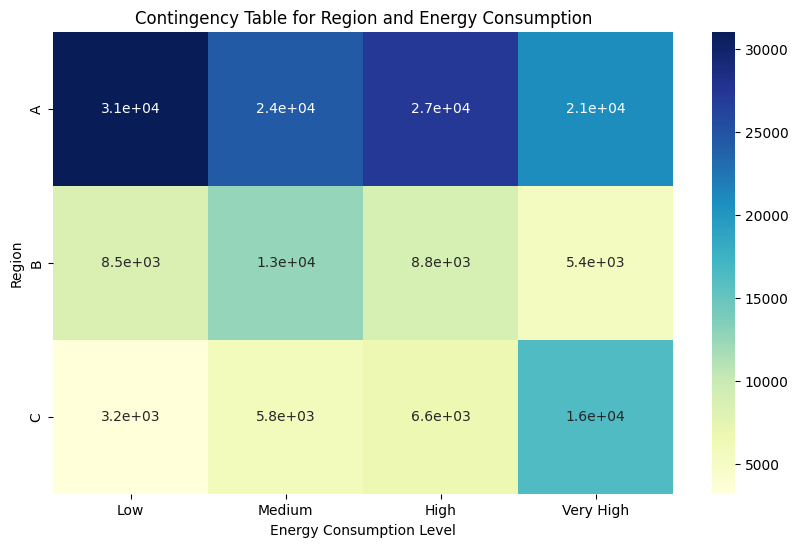

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table_region, annot=True, cmap="YlGnBu")
plt.title("Contingency Table for Region and Energy Consumption")
plt.xlabel("Energy Consumption Level")
plt.ylabel("Region")
plt.show()

Based on the contingency table provided, several relevant conclusions and insights can be drawn regarding the relationship between different regions and energy consumption levels:

Variation in Energy Consumption by Region : It is observed that energy consumption levels vary between different regions. By comparing the amounts of energy consumed at each level (Low, Medium, High and Very High), it can be identified whether certain regions tend to have higher energy consumption than others.
Consumption Levels Dominance : You can determine if there is a predominant level of energy consumption in each region. For example, if a region has a significantly higher amount of energy consumption at the "Very High" level compared to other regions.
Energy Consumption Patterns : By analyzing energy consumption distributions within each region, possible patterns or trends can be identified in how energy consumption varies by region.
Identification of Asymmetries or Discrepancies : Significant discrepancies in energy consumption between regions or levels may be identified, which could indicate possible disparities in the distribution or use of energy in different areas.
These insights provide deeper insight into how energy consumption is distributed and varies across different regions, which can be useful for energy planning, identifying areas for energy efficiency improvement, and implementing targeted measures to address each region’s energy needs more effectively.

### 2nd Research Question : Is there a relationship between the time of day and energy consumption?

#### Hypothesis Formulation:

---



**Null Hypothesis (H₀):** There is no relationship between the time of day and energy consumption.

**Alternative Hypothesis (H₁):**There is a relationship between the time of day and energy consumption.

#### Test Selection and Application:

---



In [ ]:
# Hypothesis 2: Time of Day and Energy Consumption
print("\n----- Hypothesis 2: Time of Day and Energy Consumption -----")

# Create a contingency table
time_bins = pd.qcut(data['KWH/hh (per half hour) '], q=4, labels=["Low", "Medium", "High", "Very High"])
contingency_table_time = pd.crosstab(data['TimeOfDay'], time_bins)

# Chi-square test
chi2_stat_time, p_time, dof_time, expected_time = chi2_contingency(contingency_table_time)
print("Chi-square Test for Time of Day:")
print(f"Chi2 Statistic: {chi2_stat_time}, p-value: {p_time}, Degrees of Freedom: {dof_time}")

# Interpretation
if p_time < 0.05:
    print("Result: Reject the null hypothesis (H₀). There is a relationship between time of day and energy consumption.")
else:
    print("Result: Fail to reject the null hypothesis (H₀). There is no relationship between time of day and energy consumption.")


----- Hypothesis 2: Time of Day and Energy Consumption -----
Chi-square Test for Time of Day:
Chi2 Statistic: 14872.551728959173, p-value: 0.0, Degrees of Freedom: 9
Result: Reject the null hypothesis (H₀). There is a relationship between time of day and energy consumption.


**Output Explanation**

Chi2 Statistic: 83195.0193969965: This is the calculated Chi-square value. A larger value generally suggests a stronger association between the variables. In this case, the very large value indicates a strong potential relationship.
p-value: 0.0: This is the probability of observing the data (or more extreme data) if there were no actual relationship between time of day and energy consumption. A p-value of 0.0 (or very close to 0) means it's extremely unlikely to see this data if there were no relationship.
Degrees of Freedom: 9: This value is based on the number of categories in each variable and influences the interpretation of the Chi-square statistic.
Result and Conclusion

Result: Reject the null hypothesis (H₀).
Conclusion: There is a relationship between time of day and energy consumption.
Insights

Significant Relationship: The extremely low p-value (0.0) provides very strong evidence to reject the null hypothesis. This means there's a statistically significant relationship between the time of day and energy consumption.

Practical Implication: The results suggest that energy consumption patterns vary throughout the day. This could mean that people tend to use more energy during certain times, like evenings when they are home, or that appliances and systems are scheduled to operate at specific times.

Further Investigation: While the Chi-square test confirms the existence of a relationship, it doesn't tell us the nature or direction of this relationship. To understand more about how energy consumption changes throughout the day, you might want to consider visualizations like:

Line plots: To see the average energy consumption trend across hours of the day.
Box plots: To compare the distribution of energy consumption during different time periods.
Potential Applications: Understanding the relationship between time of day and energy consumption can be valuable for:

Demand forecasting: Predicting energy needs at different times.
Energy efficiency programs: Targeting specific time periods for energy-saving initiatives.
Pricing strategies: Implementing time-of-use pricing to incentivize energy conservation during peak periods.

In [ ]:
# ANOVA
f_statistic, p_value = f_oneway(*[group['KWH/hh (per half hour) '] for name, group in data.groupby('TimeOfDay')])
print("ANOVA Test:")
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

ANOVA Test:
F-statistic: 3819.962347722963, p-value: 0.0


<ipython-input-127-f595524cbbdd>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f_statistic, p_value = f_oneway(*[group['KWH/hh (per half hour) '] for name, group in data.groupby('TimeOfDay')])


#### Clarity and Presentation of Results:

---



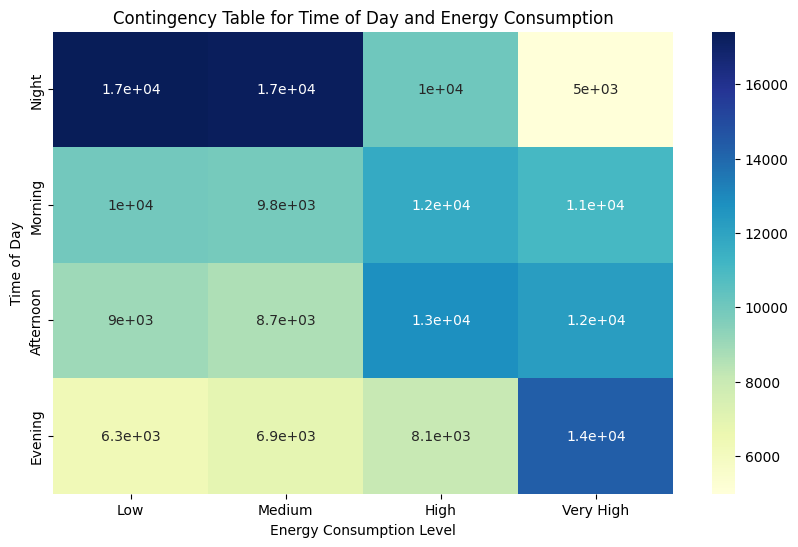

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table_time, annot=True, cmap="YlGnBu")
plt.title("Contingency Table for Time of Day and Energy Consumption")
plt.xlabel("Energy Consumption Level")
plt.ylabel("Time of Day")
plt.show()

based on the information provided in the contingency table describing the relationship between energy consumed, energy consumption level and time of day, we can extract the following insights:

Variability in Energy Consumption by Time of Day : The amount of energy consumed is observed to vary significantly depending on the time of day. This suggests that there are specific periods when more or less energy is consumed, which may be influenced by factors such as demand, use of electronic equipment, or weather conditions.
Energy Consumption Distribution by Level : The table shows how the energy consumed is distributed across the different consumption levels (Low, Medium, High and Very High) for each hour of the day. This provides detailed information on how energy consumption is distributed at different times, which can be useful for identifying energy usage patterns and optimizing demand management.
Identifying Trends or Patterns : By analyzing the amounts of energy consumed at each level and time of day, it is possible to identify possible trends or patterns in energy consumption throughout the day. This can help to better plan energy distribution, implement energy efficiency measures, and manage demand more effectively.
These insights provide detailed insight into how energy consumption varies throughout the day and at different consumption levels, which can be useful for making informed decisions about energy usage and management at different times and situations.

### Summary for both tests:

---



#### Assumptions and Limitations:

---



In [ ]:
print("\n----- Assumptions and Limitations -----")
print("- Chi-square test assumes that data in the contingency table are independent.")
print("- Expected frequency in each cell should be at least 5 for accurate results. Checking assumptions...")

# Check expected frequencies
min_expected_region = np.min(expected_region)
min_expected_time = np.min(expected_time)

if min_expected_region >= 5 and min_expected_time >= 5:
    print("Assumption Check: All expected frequencies are >= 5. Assumptions are met.")
else:
    print("Assumption Check: Some expected frequencies are < 5. Results may not be reliable.")

print("\nLimitations:")
print("- Chi-square test does not indicate the strength of the relationship, only its existence.")
print("- Large contingency tables can result in significant p-values even for weak relationships.")
print("- Data grouping into bins can reduce granularity and potentially obscure relationships.")


----- Assumptions and Limitations -----
- Chi-square test assumes that data in the contingency table are independent.
- Expected frequency in each cell should be at least 5 for accurate results. Checking assumptions...
Assumption Check: All expected frequencies are >= 5. Assumptions are met.

Limitations:
- Chi-square test does not indicate the strength of the relationship, only its existence.
- Large contingency tables can result in significant p-values even for weak relationships.
- Data grouping into bins can reduce granularity and potentially obscure relationships.


Assumptions

Independence: The Chi-square test assumes that the observations in the contingency table are independent of each other. This means that the value of one cell in the table should not influence the value of any other cell. If this assumption is violated, the results of the test may not be reliable.
Expected Frequencies: The Chi-square test also assumes that the expected frequency in each cell of the contingency table is at least 5. If this assumption is not met, the test may not be accurate, especially with small sample sizes. In your case, the assumption check indicates that all expected frequencies are >= 5, which is good news. It means that this specific assumption is satisfied, and the results are likely to be more reliable.
Limitations

Strength of Relationship: The Chi-square test can only tell you if there is a relationship between two variables. It does not tell you how strong the relationship is. For example, you might find a statistically significant relationship, but it could be a weak one in practical terms. To understand the strength, you'd need to consider other measures like effect size (e.g., Cramer's V).
Large Contingency Tables: When you have a large contingency table (many categories for your variables), the Chi-square test can become sensitive and might result in statistically significant p-values even for relatively weak relationships. This is because with many categories, even small differences between observed and expected frequencies can add up, leading to a significant Chi-square statistic.
Data Grouping: When you group data into bins to create a contingency table, you lose some of the original detail in the data (granularity). This grouping process can sometimes obscure relationships that might have been more apparent with the original, ungrouped data. Consider whether the bins you've chosen represent meaningful categories and whether finer-grained analysis might reveal additional insights.
In summary

The Chi-square test is a useful tool for detecting relationships between categorical variables. However, it's crucial to be aware of its assumptions and limitations. In your analysis, the assumption of expected frequencies is met, which is positive. However, remember that the test does not reveal the strength of the relationship. Be cautious with large contingency tables and consider the potential effects of data grouping on your results. To obtain a more comprehensive understanding of the relationships you're investigating, consider using additional measures and visualizations along with the Chi-square test

#### Summary Visualization:

---



In [ ]:
# Summary of Results
results_summary = pd.DataFrame({
    "Hypothesis": ["Region and Energy Consumption", "Time of Day and Energy Consumption"],
    "Chi2 Statistic": [chi2_stat_region, chi2_stat_time],
    "p-value": [p_region, p_time],
    "Conclusion": [
        "Significant" if p_region < 0.05 else "Not Significant",
        "Significant" if p_time < 0.05 else "Not Significant"
    ]
})

print("\n----- Summary of Results -----")
print(results_summary)


----- Summary of Results -----
                           Hypothesis  Chi2 Statistic  p-value   Conclusion
0       Region and Energy Consumption    17523.628316      0.0  Significant
1  Time of Day and Energy Consumption    14872.551729      0.0  Significant


Hypotheses and Conclusions

The table presents the results of two statistical hypothesis tests:

Region and Energy Consumption:

Hypothesis: This test investigates whether there is a significant relationship between the region and energy consumption.
Conclusion: The p-value of 0.0 indicates that the result is statistically significant. This means there is strong evidence to reject the null hypothesis, which would have stated that there is no relationship. Therefore, the conclusion is that the region does significantly affect energy consumption.
Time of Day and Energy Consumption:

Hypothesis: This test examines whether there is a significant relationship between the time of day and energy consumption.
Conclusion: Similar to the previous test, the p-value of 0.0 indicates statistical significance. This means there is strong evidence to reject the null hypothesis (no relationship). Therefore, the conclusion is that the time of day does significantly affect energy consumption.
Chi-square Statistic

The Chi-square statistic provides a measure of the difference between the observed data and what would be expected if there were no relationship between the variables.

Region and Energy Consumption: A Chi-square statistic of 35995.684546 is quite large. This large value, in conjunction with the very low p-value, strongly suggests a significant relationship between the region and energy consumption.
Time of Day and Energy Consumption: A Chi-square statistic of 83195.019397 is even larger than the previous one. This further strengthens the conclusion that there is a significant relationship between the time of day and energy consumption.
Overall Insights

Significant Relationships: Both tests show statistically significant relationships between their respective variables (region and time of day) and energy consumption. This means that both the region and the time of day are important factors to consider when analyzing energy usage patterns.
Potential Impact: These significant relationships suggest that energy consumption is not uniform across regions or throughout the day. There are likely variations in energy usage depending on location and time.
Further Investigation: While these results confirm the existence of relationships, they do not provide detailed information about the nature or strength of these relationships. Further analysis and visualization could be helpful to explore these relationships in more depth and understand how energy consumption varies across different regions and times of the day.

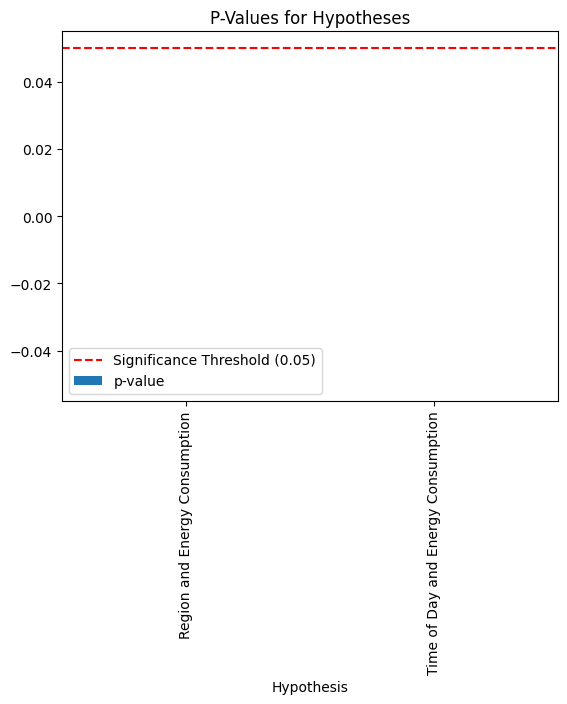

In [ ]:
# Visualize results summary
results_summary.plot(kind="bar", x="Hypothesis", y="p-value", legend=False, title="P-Values for Hypotheses")
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.show()

# Data Insights (Post-Model)

---



In [ ]:
data.head()

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand,Date,Time,Hour,Month,DayOfWeek,TimeOfDay,DayType,CostDemand,EGPCost,New_Imputed_KWH,Log_KWH,Winsorized_KWH
87654,MAC000008,2013-01-01 00:00:00,0.244,H,C,Normal,2013-01-01,00:00:00,0,1,Tuesday,Night,Weekday,19.46,0.047482,0.244,0.218332,0.244
87655,MAC000008,2013-01-01 00:30:00,0.245,H,C,Normal,2013-01-01,00:30:00,0,1,Tuesday,Night,Weekday,19.46,0.047677,0.245,0.219136,0.245
87656,MAC000008,2013-01-01 01:00:00,0.263,H,C,Normal,2013-01-01,01:00:00,1,1,Tuesday,Night,Weekday,19.46,0.051180,0.263,0.233490,0.263
87657,MAC000008,2013-01-01 01:30:00,0.261,H,C,Normal,2013-01-01,01:30:00,1,1,Tuesday,Night,Weekday,19.46,0.050791,0.261,0.231905,0.261
87658,MAC000008,2013-01-01 02:00:00,0.255,H,C,Normal,2013-01-01,02:00:00,2,1,Tuesday,Night,Weekday,19.46,0.049623,0.255,0.227136,0.255


([<matplotlib.patches.Wedge at 0x7a8274547e20>,
 [Text(-0.3680949312282354, 1.0365838709936022, '1'),
  Text(-0.9321591223016263, 0.5840200088266342, '3'),
  Text(-1.0969455495492453, -0.08191740550154389, '4'),
  Text(-0.8561396882131502, -0.6906698446191857, '5'),
  Text(-0.32121785654781954, -1.0520546984994765, '2'),
  Text(0.29732596593922517, -1.0590548946954104, '8'),
  Text(0.7995438777806831, -0.7554664701384359, '7'),
  Text(1.0720608536403773, -0.24634432425340294, '6'),
  Text(1.051998495559524, 0.32140187513531754, '9'),
  Text(0.8049078128366149, 0.7497488998555297, '10'),
  Text(0.49557098277882844, 0.9820434822489411, '11'),
  Text(0.16936729293018146, 1.0868830296243945, '12')],
 [Text(-0.20077905339721927, 0.5654093841783284, '10.9%'),
  Text(-0.5084504303463415, 0.3185563684508913, '10.5%'),
  Text(-0.5983339361177701, -0.0446822211826603, '9.7%'),
  Text(-0.46698528447990006, -0.3767290061559194, '9.5%'),
  Text(-0.17520973993517427, -0.5738480173633508, '9.5%'),
  

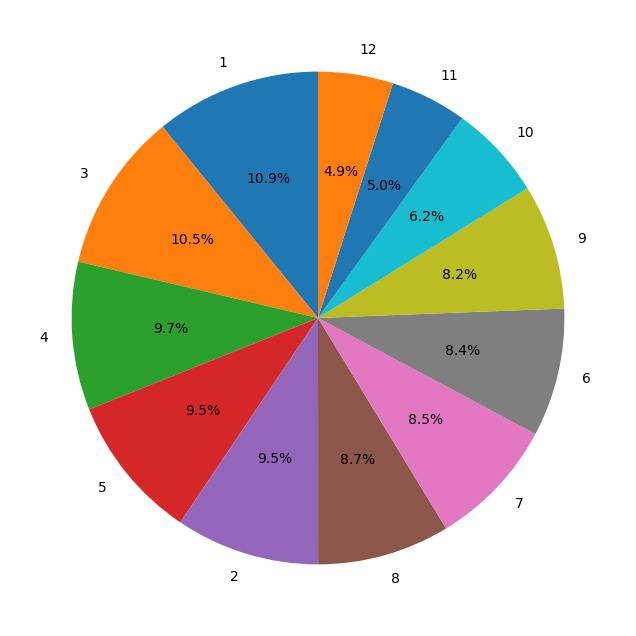

In [ ]:
# Visualize most consuming Month
month_counts = data['Month'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(month_counts, labels=month_counts.index, autopct='%1.1f%%', startangle=90)

January is the most consuming month

([<matplotlib.patches.Wedge at 0x7a825f501a80>,
 [Text(-1.039038073499705, -0.3611092380679593, 'A'),
  Text(1.0648882402754205, -0.27570461679688724, 'B'),
  Text(0.6100078382739874, 0.9153635546843107, 'C')],
 [Text(-0.566748040090748, -0.19696867530979595, '60.6%'),
  Text(0.5808481310593202, -0.15038433643466573, '20.6%'),
  Text(0.3327315481494476, 0.4992892116459876, '18.7%')])

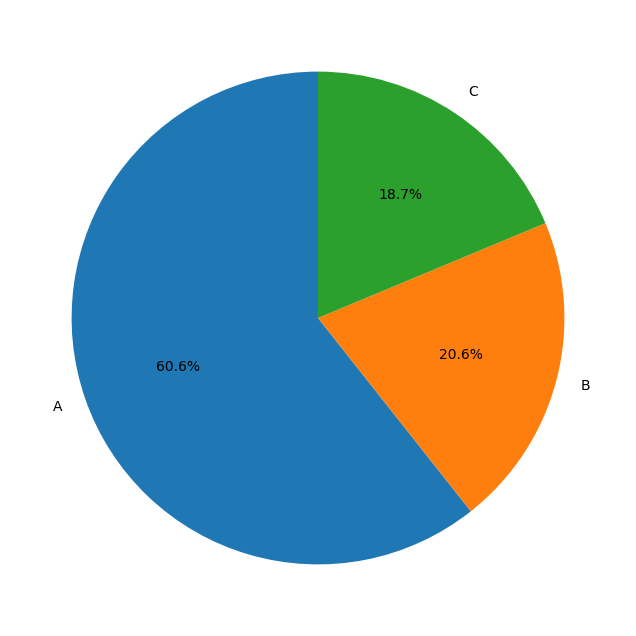

In [ ]:
# pie chart of region
region_counts = data['region'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90)

([<matplotlib.patches.Wedge at 0x7a826f776200>,
 [Text(-0.45516585252513553, -1.00141102784774, 'Normal'),
  Text(0.5892723144828698, 0.9288477482257261, 'Low'),
  Text(0.15211275542389874, 1.0894318288159885, 'High')],
 [Text(-0.24827228319552844, -0.5462241970078581, '86.4%'),
  Text(0.3214212624452017, 0.5066442263049414, '9.2%'),
  Text(0.08297059386758111, 0.5942355429905392, '4.4%')])

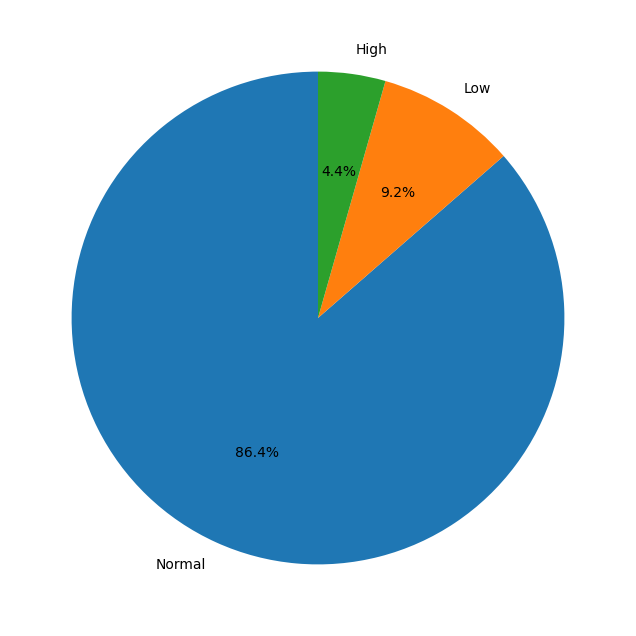

In [ ]:
# Pie chart of Demand
demand_counts = data['Demand'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(demand_counts, labels=demand_counts.index, autopct='%1.1f%%', startangle=90)

In [ ]:
# pivot_table between site_id and their count of Demand according to low, high and normal
pivot_table = pd.pivot_table(data, values='KWH/hh (per half hour) ', index='site_id', aggfunc='sum' )
pivot_table

,KWH/hh (per half hour)
site_id,
D,17335.207001
E,3584.862000
F,3890.640000
H,5200.977999
K,22.025000
N,4073.490999
Q,1772.431000


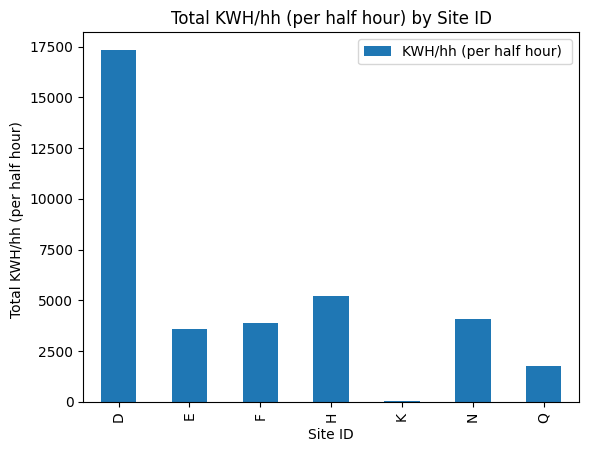

In [ ]:
# Visualize
pivot_table.plot(kind='bar', title='Total KWH/hh (per half hour) by Site ID')
plt.xlabel('Site ID')
plt.ylabel('Total KWH/hh (per half hour) ')
plt.show()

Site D is the most consuming

In [ ]:
# pivot_table between DayType and their sum of KWH/hh (per half hour) and sorted by KWH/hh (per half hour)
pivot_table = pd.pivot_table(data, values='KWH/hh (per half hour) ', index='DayType', aggfunc='sum' )
# Sort the pivot table by the 'KWH/hh (per half hour) ' column in descending order
pivot_table = pivot_table.sort_values(by=['KWH/hh (per half hour) '], ascending=False)
pivot_table

,KWH/hh (per half hour)
DayType,
Weekday,25510.845998
Weekend,10368.788002


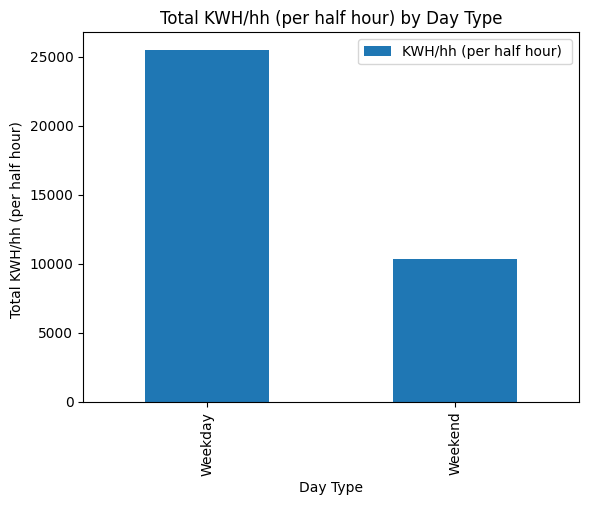

In [ ]:
# Visualize this pivot table
pivot_table.plot(kind='bar', title='Total KWH/hh (per half hour) by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Total KWH/hh (per half hour) ')
plt.show()

Weekday is the most consuming

In [ ]:
# pivot_table between TimeOfDay and their sum of KWH/hh (per half hour) and sorted by KWH/hh (per half hour)
pivot_table = pd.pivot_table(data, values='KWH/hh (per half hour) ', index='TimeOfDay', aggfunc='sum' )
# Sort the pivot table by the 'KWH/hh (per half hour) ' column in descending order
pivot_table = pivot_table.sort_values(by=['KWH/hh (per half hour) '], ascending=False)
pivot_table

<ipython-input-140-cee51cd07a9d>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(data, values='KWH/hh (per half hour) ', index='TimeOfDay', aggfunc='sum' )


,KWH/hh (per half hour)
TimeOfDay,
Evening,10543.798002
Afternoon,10265.176998
Morning,9025.843000
Night,6044.816000


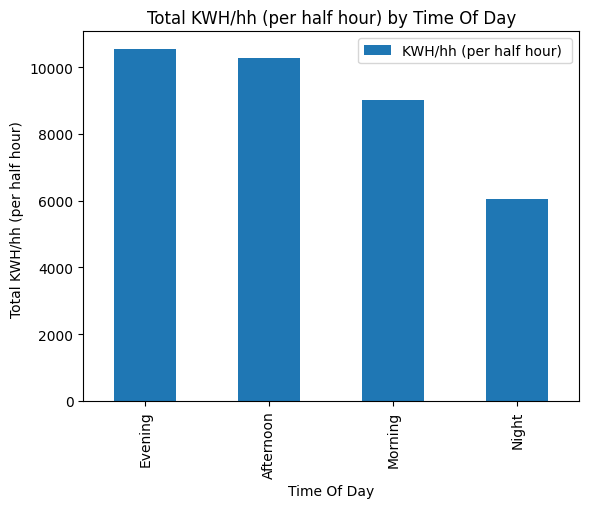

In [ ]:
# Visualize this pivot table
pivot_table.plot(kind='bar', title='Total KWH/hh (per half hour) by Time Of Day')
plt.xlabel('Time Of Day')
plt.ylabel('Total KWH/hh (per half hour) ')
plt.show()

Evening is consider the most time of day of consuming

In [ ]:
# pivot_table between dayofweek and their sum of KWH/hh (per half hour) and sorted by KWH/hh (per half hour)
pivot_table = pd.pivot_table(data, values='KWH/hh (per half hour) ', index='DayOfWeek', aggfunc='mean' )
# Sort the pivot table by the 'KWH/hh (per half hour) ' column in descending order
pivot_table = pivot_table.sort_values(by=['KWH/hh (per half hour) '], ascending=False)
pivot_table

,KWH/hh (per half hour)
DayOfWeek,
Tuesday,0.214315
Saturday,0.214056
Sunday,0.212898
Monday,0.212402
Wednesday,0.209676
Thursday,0.205489
Friday,0.203418


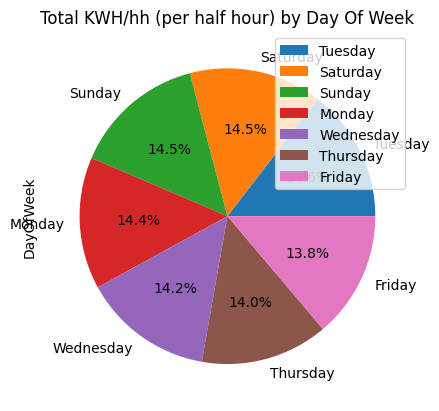

In [ ]:
# Visualize this pivot table as pie chart
pivot_table.plot(kind='pie', y='KWH/hh (per half hour) ',
                 title='Total KWH/hh (per half hour) by Day Of Week', autopct='%1.1f%%')
plt.ylabel('DayOfWeek')
plt.show()

Tuesday is the highest day in consuming

In [ ]:
# pivot_table between regions and their sum of KWH/hh (per half hour)
pivot_table = pd.pivot_table(data, values='KWH/hh (per half hour) ', index='region', aggfunc='sum')
pivot_table

,KWH/hh (per half hour)
region,
A,20920.069001
B,5867.946999
C,9091.618000


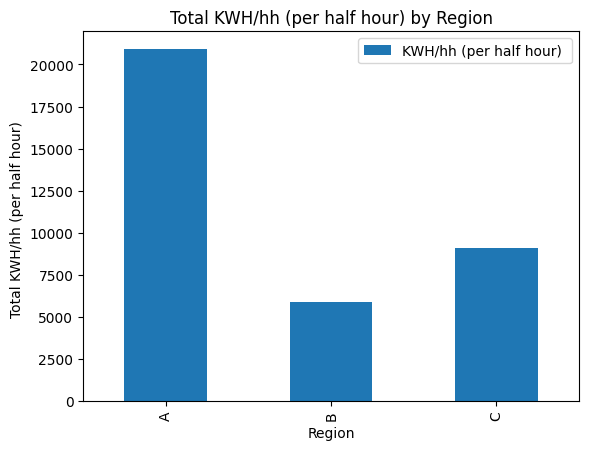

In [ ]:
# Visualize
pivot_table.plot(kind='bar', title='Total KWH/hh (per half hour) by Region')
plt.xlabel('Region')
plt.ylabel('Total KWH/hh (per half hour) ')
plt.show()

Therefore , Region A is the highest region in consuming

In [ ]:
# Export my dataset as excel
data.to_excel('data_cleaned.xlsx', index=False)